<font size = "5"> **Chapter 3:  [Imaging](Ch3-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Ronchigram

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Krishna Koirala  and Gerd Duscher, 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Load packages
### Check for Newest Versions

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2022.9.1':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load Necessary Packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
from matplotlib.patches import Circle

import pyTEMlib
from pyTEMlib import image_tools as it
from pyTEMlib import animation

import scipy.ndimage as ndimage

Populating the interactive namespace from numpy and matplotlib
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher


## Ronchigram Introduction

A ronchigram is generally a convergent beam electron diffraction pattern (CBED) in which the electron beam is NOT focused on the sample.  This experimental setup gives a so called **shadow image**. While not strictly within definition some authors refer to ronchigrams and inplicitly mean of an amorphous specimen.

John M.  Cowley https://doi.org/10.1016/S0304-3991(79)80018-2; https://doi.org/10.1016/S0304-3991(79)80021-2 laid the basis for the usage of Ronchigram in alignment of transmission electron microscopes in **scanning** and **convergent** beam mode.


The goal of the alignment is to illuminate the probe forming aperture (mostly the condensor aperture) with a coherent patch.

The Ronchigram is also used to determine the aberration function which in turn is used to correct for lens aberrations.

The following discussion of Ronchigrams depends on the following  assamptions:
 - The specimen is expressed as a 2 dimensional potential, which neglects the dependence of the electron-specimen interaction on different incident angles and all dynamical effects. 

- Fresnel diffraction is neglected which causes contrast reversal of particles and at voids.  Diffraction is assumed to be  purely in the Fraunhofer regime. 

- Bragg diffraction and the associated interference of diffracted beams is omitted.

Therefore the following discussion is reduced to Ronchigrams of thin amorphous samples of a light element. This is incidentally the sample of choice for alignemnt in STEM mode. 

### Aberration Function $\chi$

Please see this notebook for a more detailed discussion of the [Aberration Function](CH3-CTF.ipynb#Aberrations)

With the main aberration coefficients $C_{n,m}$:

Coefficient  Nion | CEOS | Name
 ----------------|------------- | -------------
 $C_{10}$ | $A_1$ |defocus
 $C_{12a}$, $C_{12b}$  | $B_1$ |astigmatism
 $C_{21a}$, $C_{21b}$  | $A_2$ |coma
 $C_{23a}$, $C_{23b}$  | $B_2$ |three-fold astigmatism
 $C_{30}$  | $A_3$ |spherical aberration
    
As before the aberration function $\chi$ in polar coordinates (of angles) $\theta$ and $\phi$ is defined according to [Krivanek et al.](https://doi.org/10.1016/S0304-3991(99)00013-3):

$$
\chi(\theta, \phi) = \sum_n \theta^{n+1} *\frac{1}{n+1} * \sum_{n} C_{n,m,a}  \cos(m*\phi) + C_{n,m,b} \sin(m*\phi) 
$$

with:
- $n$: order ($n=0,1,2,3,...$)
- $m$: symmetry  $m = ..., n+1$;  
    - $m$ is all odd   for n = even
    - $m$ is all even  for n = odd

    

In the following we program the equation above just as seen. The terms are divided into the theta (line 22) and the sum part (line 33).  The product of these two terms is summed in line 39.

We assume that the aberrations are given up to fifth order.




In [2]:
def make_chi( phi, theta, aberrations):
    maximum_aberration_order = 5
    chi = np.zeros(theta.shape)
    for n in range(maximum_aberration_order+1):  ## First Sum up to fifth order
        term_first_sum = np.power(theta,n+1)/(n+1) # term in first sum
                
        second_sum = np.zeros(theta.shape)  ## second Sum intialized with zeros
        for m in range((n+1)%2,n+2, 2):
            if  m >0: 
                if f'C{n}{m}a' not in aberrations: # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}a'] = 0.
                if f'C{n}{m}b' not in aberrations:
                    aberrations[f'C{n}{m}b'] = 0.
                    
                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}a'] *np.cos(m* phi) + aberrations[f'C{n}{m}b'] *np.sin(m* phi)
            else:
                if f'C{n}{m}' not in aberrations: # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}'] =  0.
                    
                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}']
        chi = chi + term_first_sum * second_sum *2*np.pi/ aberrations['wavelength']
        
    return chi

## Goal
We want to illuminate an aperture with as coherent (homogeneous) wave as possible. In the ideal all points have the same amplitude an dphase which we associate with a 1.0 and zero outside.

That ideal situation allows us in the code cell below to study the influence of the aperture size on probe size.

<IPython.core.display.Javascript object>


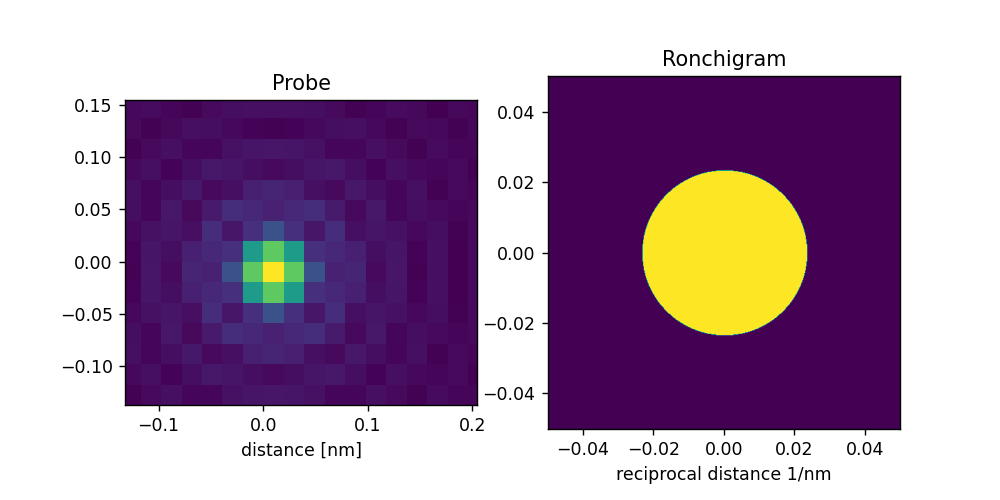

Text(0.5, 1.0, 'Ronchigram')

In [78]:
# ---Input  ----
convergence_angle = 30 # in mrad
FOV = 10 # in 1/nm
# ---------------

ApAngle=convergence_angle/1000.0 # in rad

wl = it.get_wavelength(ab['acceleration_voltage'])
sizeX = sizeY = 512

## Reciprocal plane in 1/nm
dk = 1/FOV
kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
Txv, Tyv = np.meshgrid(kx, ky)

# define reciprocal plane in angles
phi =  np.arctan2(Txv, Tyv)
theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

## Aperture function 
mask = theta >= ApAngle

aperture =np.ones((sizeX,sizeY),dtype=float)
aperture[mask] = 0.
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((np.abs(np.fft.fftshift(np.fft.ifft2(aperture)))), extent = [-int(FOV/2),int(FOV/2),-int(FOV/2),int(FOV/2)])
ax[0].set_xlabel('distance [nm]')
ax[0].set_title('Probe')
ax[1].imshow(aperture, extent = [-(1/FOV/2),(1/FOV/2),-(1/FOV/2),(1/FOV/2)])
ax[1].set_xlabel('reciprocal distance 1/nm')
ax[1].set_title('Ronchigram')


We see that increasing the size of an coherently illuminated aperture is reducing the probe diameter and therefore improving spatial resolution. The goal is to obtain an as large radius as possible of quasi-coherent area (in reciprocal space) match it with an aperture and use that as a probforming configuration.

The Ronchigram will get us that coherent illumination and we will discuss this Ronchigram in detail in this notebook.

## Calculate Ronchigram

Setting up the meshes of angles $\phi$ and $\theta$ in polar coordinates for which the aberrations will be calculated.
This is analog to what we did in the [Aberration Function notebook](CH3-03CTF.ipynb#Aberrations).


In [3]:

def get_chi( ab, sizeX, sizeY, verbose= False):      
    """
    ####
    # Internally reciprocal lattice vectors in 1/nm or rad.
    # All calculations of chi in angles.
    # All aberration coefficients in nm
    """
    ApAngle=ab['convergence_angle']/1000.0 # in rad

    wl = it.get_wavelength(ab['acceleration_voltage'])
    if verbose:
        print(f"Acceleration voltage {ab['acceleration_voltage']/1000:}kV => wavelength {wl*1000.:.2f}pm")
              
    ab['wavelength'] = wl


    ## Reciprocal plane in 1/nm
    dk = 1/ab['FOV']
    kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
    ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
    Txv, Tyv = np.meshgrid(kx, ky)

    # define reciprocal plane in angles
    phi =  np.arctan2(Txv, Tyv)
    theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

    ## calculate chi 
    chi = (make_chi(phi,theta,ab))
    
    ## Aperture function 
    mask = theta >= ApAngle

    aperture =np.ones((sizeX,sizeY),dtype=float)
    aperture[mask] = 0.

    
    return chi, aperture



The calculation of a ronchigram is described by  [Sawada et al.](https://doi.org/10.1016/j.ultramic.2008.04.095).

A point source $\delta (r)$ illuminates a probe-forming lens, which has a transfer function $T(k)$ given by ([Cowley, Ultramicroscopy 1979 - eq.1](https://doi.org/10.1016/S0304-3991(79)80021-2)\

$$
T(k) = A(k) \exp \left(-i \chi(k) \right)
$$ 

where 
- $A(k)$ is the aperture function and 
- $\chi(k)$ is our aberration function from above.


In [4]:
#camera length as field of view in mrad 
sizeX = sizeY =512

ab ={}
ab['FOV'] = 20 # in nm
ab['convergence_angle'] = 120 ## let have a little bit of a view
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])*10

ab['C10'] = -1590
ab['C30'] = 2.2e6
ab['Cc'] = ab['C30']
 
chi, A_k = get_chi( ab, sizeX, sizeY)

T_k =   A_k * np.exp(-1j*chi)

Provided that the projected potential of a thin specimen is given by $\phi(r)$, the effect of the specimen on exitwave $\psi (r)$ is to multiply the exit wave by a transmission function $q(r) = \exp(-i\sigma \phi(r)$), where $\sigma$ is the interaction constant. 

The amplitude distribution on the plane of observation is given by the Fourier transform of the exit wave at the specimen $\psi(r) = q(r) \cdot t(r)$  as follows:

$$
\Psi(k) = Q(k) \circledast  T(k) 
$$, 

where the symbol $\circledast$ represents a convolution operation. The convolution is a multiplication in Fourier space, so the fourier transfrom of the product of $q(r)$ and $ t(r)$ gives $\Psi$



In [5]:
V_noise  =np.random.rand(sizeX,sizeY)
smoothing = 5
phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

sigma = 6 ## 6 for carbon and thin

q_r = np.exp(-1j*sigma * phi_r)
#q_r = 1-phi_r * sigma

T_k =  (A_k)*(np.exp(-1j*chi))
t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))


The Ronchigram pattern $I(k)$ is given by:

$$
I(k) = |\psi(k) \cdot \overline{\psi(k)}|
$$,

where $\overline{\psi}$ is the complex conjugate of $\psi$.

In [9]:
def print_abberrations(ab):
    from IPython.display import HTML, display
    output = '<html><body>'
    output+= f"Abberrations [nm] for acceleration voltage: {ab['acceleration_voltage']/1e3:.0f} kV"
    output+= '<table>'
    output+= f"<tr><td> C10 </td><td> {ab['C10']:.1f} </tr>"
    output+= f"<tr><td> C12a </td><td> {ab['C12a']:20.1f} <td> C12b </td><td> {ab['C12b']:20.1f} </tr>"
    output+= f"<tr><td> C21a </td><td> {ab['C21a']:.1f} <td> C21b </td><td> {ab['C21b']:.1f} "
    output+= f"    <td> C23a </td><td> {ab['C23a']:.1f} <td> C23b </td><td> {ab['C23b']:.1f} </tr>"
    output+= f"<tr><td> C30 </td><td> {ab['C30']:.1f} </tr>"
    output+= f"<tr><td> C32a </td><td> {ab['C32a']:20.1f} <td> C32b </td><td> {ab['C32b']:20.1f} "
    output+= f"<td> C34a </td><td> {ab['C34a']:20.1f} <td> C34b </td><td> {ab['C34b']:20.1f} </tr>"
    output+= f"<tr><td> C41a </td><td> {ab['C41a']:.3g} <td> C41b </td><td> {ab['C41b']:.3g} "
    output+= f"    <td> C43a </td><td> {ab['C43a']:.3g} <td> C43b </td><td> {ab['C41b']:.3g} "
    output+= f"    <td> C45a </td><td> {ab['C45a']:.3g} <td> C45b </td><td> {ab['C45b']:.3g} </tr>"
    output+= f"<tr><td> C50 </td><td> {ab['C50']:.3g} </tr>"
    output+= f"<tr><td> C52a </td><td> {ab['C52a']:20.1f} <td> C52b </td><td> {ab['C52b']:20.1f} "
    output+= f"<td> C54a </td><td> {ab['C54a']:20.1f} <td> C54b </td><td> {ab['C54b']:20.1f} "
    output+= f"<td> C56a </td><td> {ab['C56a']:20.1f} <td> C56b </td><td> {ab['C56b']:20.1f} </tr>"
    output+= f"<tr><td> Cc </td><td> {ab['Cc']:.3g} </tr>"

    output+='</table></body></html>'

    display(HTML(output))


<IPython.core.display.Javascript object>


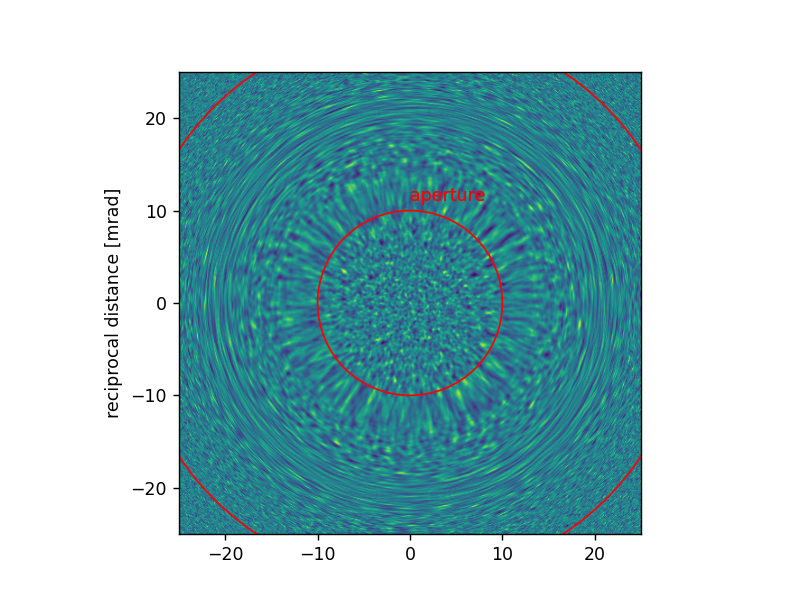

In [79]:
from matplotlib.patches import Circle
# in nm
ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

## scale of ronchigram
FOV_reciprocal = 1/ab['FOV']*sizeX/2 
extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
ylabel = 'reciprocal distance [1/nm]'

FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
ylabel = 'reciprocal distance [mrad]'


plt.figure()
plt.imshow(ronchigram, extent = extent)
plt.ylabel(ylabel)
#plt.imshow(phi_r)

print_abberrations(ab)
condensor_aperture = Circle((0, 0), radius = 10, fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture);

In [80]:
from matplotlib.patches import Circle
# in nm
ab ={}
ab['C10'] =  -0#0.16957899999999998
ab['C12a'] =  32.42161
ab['C12b'] =  0.9639660000000001
ab['C21a'] =  -114.478
ab['C21b'] =  -30.4613
ab['C23a'] =  2.4295
ab['C23b'] =  -17.3943
ab['C30'] =  2.2e6
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])


ronchi_FOV = 100 #mrad
ab['FOV'] = 1/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 10 ## let have a little bit of a view

ab['Cc']= 1e6
ab = get_target_aberrations("NionUS200",200000)
ab['C10'] = -0
ronchi_FOV = 100 #mrad
ab['FOV'] = 1/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
chi, A_k  = get_chi( ab, sizeX, sizeY)

phase_plate =  np.cos(-chi)

## scale of ronchigram
FOV_reciprocal = 1/ab['FOV']*sizeX/2 
extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
ylabel = 'reciprocal distance [1/nm]'

FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
ylabel = 'reciprocal distance [mrad]'


#plt.imshow(phi_r)

print_abberrations(ab)
condensor_aperture = Circle((0, 0), radius = 30, fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture);

 **** Using Target Values at 200.0kV for Aberrations of NionUS200****


## Effect of Aberrations on Ronchigram
to make it easy to look at the effect of aberrations, the above code is collected in a single function: get_ronchigram.

In [17]:
def get_ronchigram(size, ab, scale = 'mrad' ):
    sizeX = sizeY = size
    chi, A_k  = get_chi( ab, sizeX, sizeY)
    
    V_noise  = np.random.rand(sizeX,sizeY)
    smoothing = 5
    phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

    sigma = 6 ## 6 for carbon and thin

    q_r = np.exp(-1j*sigma * phi_r)
    #q_r = 1-phi_r * sigma

    T_k =  (A_k)*(np.exp(-1j*chi))
    t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

    Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))


    ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

    FOV_reciprocal = 1/ab['FOV']*sizeX/2 
    if scale == '1/nm':
        extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
        ylabel = 'reciprocal distance [1/nm]'
    else :
        FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
        extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
        ylabel = 'reciprocal distance [mrad]'
    ab['chi'] = chi
    ab['ronchi_extent'] = extent
    ab['ronchi_label'] = ylabel
    return ronchigram


The effect of defocus $C_{10}$ and astigmatism $C_{12a}$ and $C_{12b}$ on the ronchigram can be explored below.
Also change coma $C_{21a}$ and $C_{21b}$ and spherical aberration  $C_{30}$ or anyother aberration you might want to test.

<IPython.core.display.Javascript object>


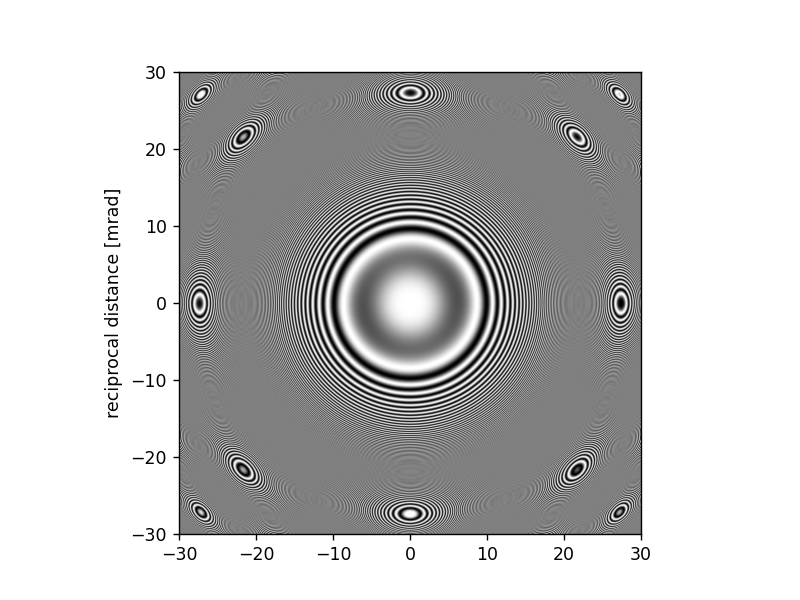

<IPython.core.display.Javascript object>


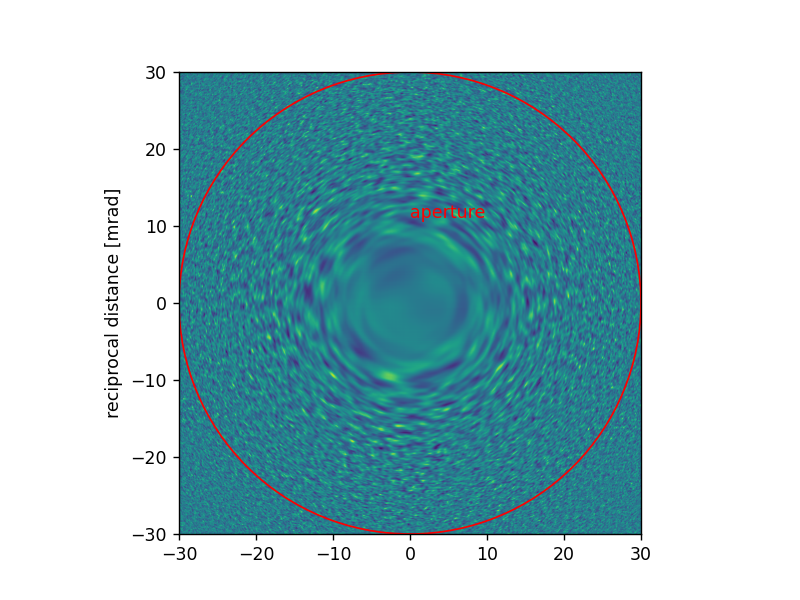

In [18]:
ab ={}
ab['C10'] =  -80#0.16957899999999998
ab['C12a'] =  2.42161
ab['C12b'] =  0.9639660000000001
ab['C21a'] =  -114.478
ab['C21b'] =  -30.4613
ab['C23a'] =  2.4295
ab['C23b'] =  -17.3943
ab['C30'] =  2.2e6
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])

ronchi_FOV = 60 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 570 ## let have a little bit of a view
ab['Cc']= 1e6
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )
phase_plate =  np.cos(-ab['chi'])
plt.figure()
plt.imshow(phase_plate, extent = ab['ronchi_extent'], cmap='gray')
plt.ylabel(ylabel)

plt.figure()
plt.imshow((ronchigram), extent = ab['ronchi_extent'])
plt.ylabel(ab['ronchi_label'])
print_abberrations(ab)
    

condensor_aperture = Circle((0, 0), radius = 30, fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture)

## Magnification in Ronchigram
The key to understand how the ronchigram is used to analyse aberrations is to determine how  magnifcation changes within ronchigrams. 


In underfocus ($C_{10} <0$) the ronchigram shows the sample at three different places.
The center part and the outer part are easily distinguishable.
However there is a third part between the two circular features.

The two circula features are the radial (inner wheel like circle) and azimutal circle of infinite magnification.

In the outer part of the sample image, the change in magnification is obvious. However, all three parts of the sample show a change of magnification. The inner part is also a underfocused and the outer one an overfocused image.

<IPython.core.display.Javascript object>


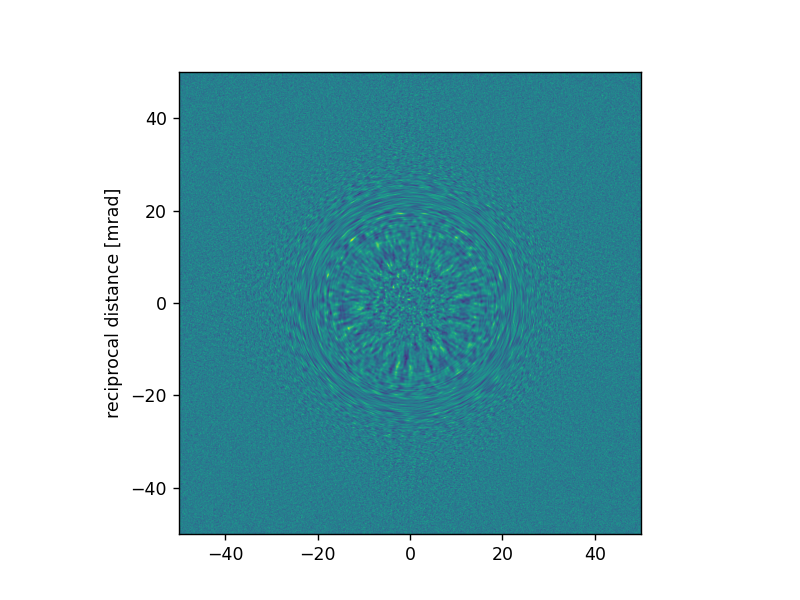

In [19]:
ab ={}
ab['C10'] =  -1000.#0.16957899999999998
ab['C30'] =  2.0e6
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])

ronchi_FOV = 100 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 100 ## let have a little bit of a view
ab['Cc']= 1e6
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )

plt.figure()
plt.imshow((ronchigram), extent = ab['ronchi_extent'])
plt.ylabel(ab['ronchi_label'])
print_abberrations(ab)


### Hessian Matrix and Magnification

For a conventional (non-aberration corrected)TEM only defocus $C_{10}$ and spherical aberration $C_{30}$ 
determine the resoltution. So let's only consider those aberrations.

The Hessian matrix in two dimensions is defined as:

$$
H f(x,y) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x\, \partial y} \\
 \frac{\partial^2 f}{\partial x\, \partial y} & \frac{\partial^2 f}{\partial y^2}
\end{bmatrix}
$$

For the aberration function, the coeffcients of the Hessian matrix are then:
$$
\frac{\partial^2 \chi}{\partial \alpha\partial \beta} = C_{3,0} (2\alpha\beta)\\
$$

$$
\frac{\partial^2 \chi}{\partial \beta^2} = C_{1,0}  + C_{3,0} (\alpha^2+3\beta^2)\\
$$

$$
\frac{\partial^2 \chi}{\partial \alpha^2} =  C_{1,0} +  C_{3,0} (3\alpha^2 +\beta^2)
$$

\begin{align}
 |H \chi| &=& \left( \frac{\partial^2 \chi}{\partial \alpha^2} \frac{\partial^2 \chi}{\partial \beta^2} \right)  - \left( \frac{\partial^2 \chi}{\partial \alpha\partial \beta} \right)^2 \\
 &=&  C_{10}^2 + 4 C_{10}C_{30} (\alpha^2 + \beta^2) + 3 C_{30}^2 (\alpha^2 + 2 \alpha \beta + \beta^2)\\
&=& C_{10}^2 + 4 C_{10}C_{30} \rho^2 + 3 C_{30}^2 \rho^4\\
&=& (C_{10} + 3 C_{30} \rho^2) (C_{10} +  C_{30} \rho^2) \\
\end{align}

where we substituted  $\rho = (\alpha^2 +\beta^2)$ (part of a polar coordinate transform):

The magnification in a ronchigram is directly proportional to 1/H ([Delby et al 2001](https://doi.org/10.1093/jmicro/50.3.177) (magnification $M = \frac{D}{\lambda} (H \chi)^{-1}$) and so the infinite magnification occurs where $H \chi=0$


Now for $(H \chi)= 0$ we get two possible solutions:
$$\rho = \sqrt{\frac{C_{10}}{3C_{30}}}$$
and 
$$\rho = \sqrt{\frac{C_{10}}{C_{30}}}$$

which are the radii of radial and azimutal circles of infinitive magnification. (A negative radius just does not make sense and so I omitted those solutions (thanks Neng).

Change the defocus to see the change between azimutal (orange) and radial (red) circle of infinite magnification.

<IPython.core.display.Javascript object>


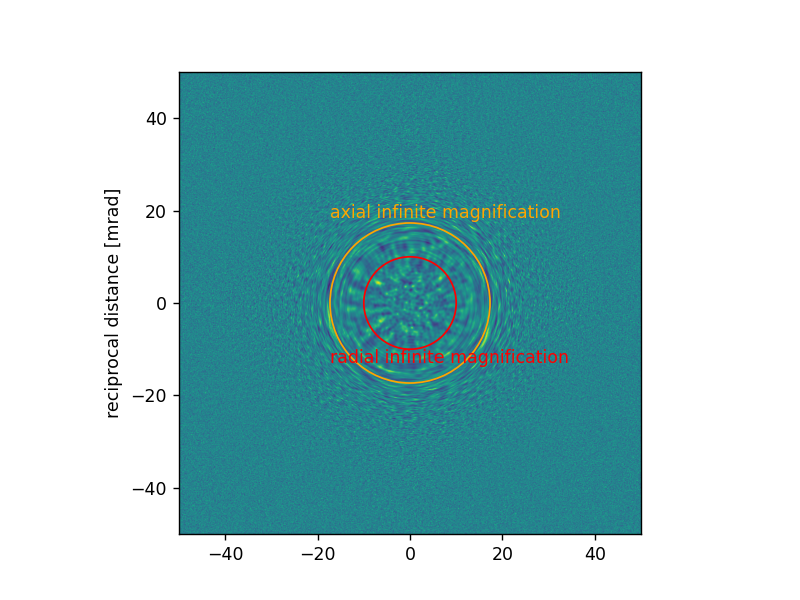

17.320508075688775 10.0


In [33]:
ab ={}
ab['C10'] =  -600.#0.16957899999999998
ab['C30'] =  2.0e6
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])

ronchi_FOV = 100 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 100 ## let have a little bit of a view
ab['Cc']= 1e6
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )

plt.figure()
plt.imshow((ronchigram), extent = ab['ronchi_extent'])
plt.ylabel(ab['ronchi_label'])
print_abberrations(ab)

radial_radius = np.sqrt(-ab['C10']/3/ab['C30'])*1000 #from rad to mrad
azimutal_radius = np.sqrt(-ab['C10']/ab['C30'])*1000 #from rad to mrad
print(azimutal_radius,radial_radius)
azimutal_circle = Circle((0, 0), radius = azimutal_radius, fill = False, color = 'orange')
plt.gca().add_patch(azimutal_circle)
plt.text(-azimutal_radius,azimutal_radius+1,s='axial infinite magnification', color = 'orange')

radial_circle = Circle((0, 0), radius = radial_radius, fill = False, color = 'red')
plt.text(-azimutal_radius,-radial_radius-3,s='radial infinite magnification', color = 'red')
plt.gca().add_patch(radial_circle);

### Geometric Origin of Circles of Infinite Magnification

In the interactive schematic below notice which rays havee a crossover at the location of the sample.

The gray ideal rays close to the optic axis cross below (after) the sample, which is defined as underfocus.

The next easy to understand is the axial circle of infinite magnificaton which is orange below and in  the image above. There the aberrated arrays cross exactly at the sample and are in focus, which constitutes infinite magnification (or diffraction).

Two radially different rays cross at the sample location and give the radial circle of infinite magnififcation (red).

Even more aberrated rays are overfocused.

Box(children=(ToggleButton(value=False, description='ideal rays'), ToggleButton(value=False, description='radi…

<IPython.core.display.Javascript object>


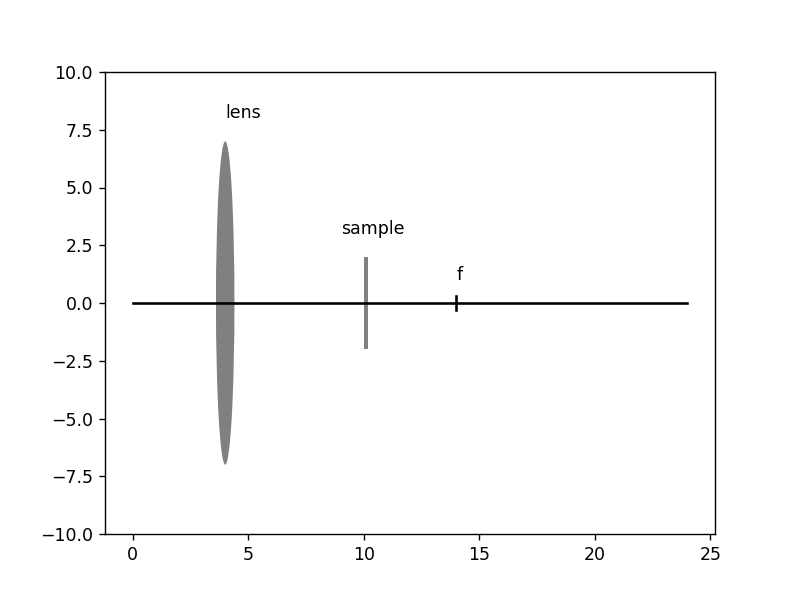

In [34]:
view_i = pyTEMlib.animation.InteractiveRonchigramMagnification()

### Infinite Magnification of Non-Rotational Aberrations

Infinite magnification in a ronchigram was defined as the zero of Jacobian ($H=0$), which is valid even for non-centro symmetric aberrations, but now we need to calculate the partial double derivatives of $\chi$, which is the Hessian matrix

### Carthesian Coordinate of $\chi$
To derive the Hessian matrix we need all the different partial derivatives of $\chi$ and that is best done in carthesiam coordinates. This becomes messy very quickly that is why most authors restrict this up to 3$^{rd}$ order. To look at the carthesian coordinate as complex vectors. (Please note, that we omit a possible shift:$C_{01}$)

\begin{align}
\chi(k) &= \frac{2 \pi}{\lambda}* & (  \frac{1}{2} \left[ C_{10}k^*k   + C_{12} {k^*}^2\right]\\
&+& \frac{1}{3} \left[ C_{21}{k^*}^2k + C_{23} {k^*}^3\right]\\
&+& \frac{1}{4} \left[ C_{30}{k^*}^2k^2 +C_{32} {k^*}^3k +C_{34} {k^*}^4\right]\\   
&+& \frac{1}{5} \left[ C_{41}{k^*}^3k^2 +C_{43} {k^*}^4k +C_{45} {k^*}^5\right]\\
&+& \frac{1}{6} \left[ C_{50}{k^*}^3k^3 +C_{52}{k^*}^4k^2+ +C_{54} {k^*}^5k+C_{56} {k^*}^6\right] ) \\   
\end{align}

And explicitly, so that we can get the second (partial) derivatives more easily
>with $ k = \alpha + i\beta$

\begin{align*}
\chi(\alpha, \beta) &=\frac{2 \pi}{\lambda} * & (  C_{1,0} (\alpha^2 +\beta^2)/2 + C_{1,2a} (\alpha^2 -\beta^2)/2 - C_{1,2b} (\alpha\beta)\\
&& + C_{2,1a} \alpha(\alpha^2 +\beta^2)/3 - C_{2,1b} \beta(\alpha^2 +\beta^2)/3
 + C_{2,3a} \alpha(\alpha^2 -3\beta^2)/3 - C_{2,3b} \beta(3\alpha^2 -\beta^2)/3 \\
&& + C_{3,0} (\alpha^2 +\beta^2)^2/4\\
&& + C_{3,2a} (\alpha^4 -\beta^4)/4 - C_{3,2b} (\alpha\beta)(\alpha^2 +\beta^2)/2
+ C_{3,4a} (\alpha^4 -6\alpha^2\beta^2+\beta^2)/4 - C_{3,4b} (\alpha^3\beta -\alpha\beta^3)\\
&& + C_{41a} ( \alpha^5  + 2*\alpha^3\beta^2 + \alpha\beta^4)/5 -  C_{41b} ( \alpha^4\beta + 2\alpha^2\beta^3 + \beta^5 )/5 
+ C_{43a} ( \alpha^5 - 2\alpha^3\beta^2 - 3*\alpha*\beta^4 )/5 
   - C_{43b} ( 3\alpha^4\beta + 2\alpha^2\beta^3 - \beta^5 )/5  \\ 
&& + C_{45a} ( \alpha^5 - 10\alpha^3\beta^2 + 5\alpha\beta^4 )/5
   - C_{45b} (5\alpha^4\beta - 10\alpha^2\beta^3 + \beta^5 )/5\\
&& + C_{50} ( \alpha^6 + 3\alpha^4\beta^2 + 3\alpha^2\beta^4 + \beta^6 )/6\\  
&& + C_{52a} ( \alpha^6 + \alpha^4\beta^2 - \alpha^2\beta^4 - \beta^6 )/6
   - C_{52b} ( \alpha^5\beta + 2\alpha^3\beta^3 + \alpha\beta^5)/3 
 + C_{54a} ( \alpha^6 - 5\alpha^4\beta^2 - 5\alpha^2\beta^4 + \beta^6 )/6
   - C_{54b} 2/3 *( \alpha^5\beta - \alpha\beta^5 )  \\
&& + C_{56a} ( \alpha^6 - 15\alpha^4\beta^2 + 15\alpha^2\beta^4 - \beta^6 )/6
- C_{56b} ( 3\alpha^5\beta - 10\alpha^3\beta^3 + 3\alpha\beta^5 )/3\\
\end{align*}

Which then in a code cell looks like this in a code cell

In [22]:
def get_chi_2(ab, u, v):
    chi1 =    ab['C10']  * (u**2 + v**2)/2 \
            + ab['C12a'] * (u**2 - v**2)/2 \
            - ab['C12b'] * u*v
    
    
    chi2 =    ab['C21a'] * (u**3 + u*v**2)/3 \
            - ab['C21b'] * (u**2*v + v**3)/3 \
            + ab['C23a'] * (u**3 - 3*u*v**2)/3 \
            - ab['C23b'] * (3*u**2*v - v**3)/3 
    
    chi3 =    ab['C30']  * (u**4 + 2*u**2*v**2 + v**4)/4 \
            + ab['C32a'] * (u**4 - v**4 )/4 \
            - ab['C32b'] * (u**3*v + u*v**3)/2 \
            + ab['C34a'] * (u**4 - 6*u**2*v**2 + v**4)/4 \
            - ab['C34b'] * (4*u**3*v - 4*u*v**3)/4
    
    chi4 =    ab['C41a'] * (u**5 + 2*u**3*v**2 + u*v**4)/5 \
            - ab['C41b'] * (u**4*v + 2*u**2*v**3 + v**5)/5 \
            + ab['C43a'] * (u**5 - 2*u**3*v**2 - 3*u*v**4)/5 \
            - ab['C43b'] * (3*u**4*v + 2*u**2*v**3 - v**5)/5 \
            + ab['C45a'] * (u**5 - 10*u**3*v**2 + 5*u*v**4)/5 \
            - ab['C45b'] * (5*u**4*v -10*u**2*v**3+ v**5)/5

    chi5 =     ab['C50']  *( u**6 + 3*u**4*v**2 + 3*u**2*v**4 + v**6 )/6\
             + ab['C52a'] * (u**6 + u**4*v**2 - u**2*v**4 - v**6 )/6\
             - ab['C52b'] * (2*u**5*v + 4*u**3*v**3 + 2*u*v**5)/6 \
             + ab['C54a'] * (u**6 - 5*u**4*v**2 - 5*u**2*v**4 + v**6)/6  \
             - ab['C54b'] * (4*u**5*v - 4*u*v**5)/6 \
             + ab['C56a'] * (u**6 - 15*u**4*v**2 + 15*u**2*v**4 - v**6 )/6\
             - ab['C56b'] * (6*u**5*v - 20*u**3*v**3 + 6*u*v**5)/6

    chi = chi1+chi2+chi3+chi4+chi5
    return chi * 2*np.pi / ab['wavelength']
    

The second derivative in $\alpha$ only  in that notation is then:

\begin{align}
\frac{\partial^2 \chi}{\partial \alpha^2} &=\frac{2 \pi}{\lambda} * & [ C_{1,0}   + C_{1,2a}   \\
&& + C_{2,1a} 2\alpha - C_{2,1b}  2/3 \beta + C_{2,3a} 2 \alpha  -  C_{2,3b} 2\beta  \\
&& + C_{3,0} (3\alpha^2 +\beta^2) + C_{3,2a} 3\alpha^2 - C_{3,2b} 3\beta\alpha + C_{3,4a} 3 (\alpha^2 -\beta^2) - C_{3,4b} 6\alpha\beta\\
&& + C_{41a}  *4/5 * ( 5\alpha^3+3 \alpha \beta^2) - C_{41b}  * 4/5 * (3 \alpha^2 \beta+ \beta^3) 
           + C_{43a} * 4/5 *  (5\alpha^3-3 \alpha \beta^2) - C_{43b}  * 4/5 * (9 \alpha^2 \beta+ \beta^3) \\
&&  + C_{45a}  4   (\alpha^3 - 3 \alpha \beta^2) - C_{45b}   4    (3 \alpha^2 \beta- \beta^3)\\
&& + C_{50}   (5 \alpha^4 + 6 \alpha^2 \beta^2 + \beta^4) \\
&& + C_{52a}   (15 \alpha^4 + 6 \alpha^2 \beta^2 - \beta^4)/3 \
   - C_{52b}   (20 \alpha^3 \beta + 12 \alpha \beta^3 )/3 
 C_{54a}   5/3  (3 \alpha^4 - 6 \alpha^2 \beta^2 - \beta^4) \
   - C_{54b}   5/3  (8 \alpha^3 \beta)  \\
&&    + C_{56a}   5  (\alpha^4 - 6 \alpha^2 \beta^2 + \beta^4) \
   - C_{56b}   20  (\alpha^3 \beta - \alpha \beta^3)]
\end{align}

The same formula as a python code is:

In [23]:
def get_d2chidu2(ab, u, v):
    d2chi1du2 =    ab['C10'] + ab['C12a']
    
    d2chi2du2 =   ab['C21a'] * 2 * u \
                - ab['C21b'] * 2/3 * v \
                + ab['C23a'] * 2 * u \
                - ab['C23b'] * 2 * v
    
    d2chi3du2 =   ab['C30']  * (3*u**2 + v**2) \
                + ab['C32a'] * 3*u**2  \
                - ab['C32b'] * 3*u*v \
                + ab['C34a'] * (3*u**2 - 3*v**2) \
                - ab['C34b'] * 6*u*v
    
    d2chi4du2 =   ab['C41a'] * 4/5*(5*u**3 + 3*u*v**2) \
                - ab['C41b'] * 4/5*(3*u**2*v + v**3) \
                + ab['C43a'] * 4/5*(5*u**3 - 3*u*v**2 ) \
                - ab['C43b'] * 4/5*(9*u**2*v + v**3) \
                + ab['C45a'] * 4*(u**3 - 3*u*v**2) \
                - ab['C45b'] * 4*(3*u**2*v - v**3) 
    
    d2chi5du2 =   ab['C50']  * (5*u**4 + 6*u**2*v**2 + v**4) \
                + ab['C52a'] * (15*u**4 + 6*u**2*v**2 - v**4)/3 \
                - ab['C52b'] * (20*u**3*v + 12*u*v**3)/3 \
                + ab['C54a'] * 5/3 * (3*u**4 - 6*u**2*v**2 - v**4) \
                - ab['C54b'] * 5/3 * (8*u**3*v)  \
                + ab['C56a'] * 5 * (u**4 - 6*u**2*v**2 + v**4) \
                - ab['C56b'] * 20 * (u**3*v - u*v**3)

    d2chidu2 = d2chi1du2 + d2chi2du2 + d2chi3du2 + d2chi4du2 + d2chi5du2
    return d2chidu2


The second derivative in $\alpha$ and $\beta$  in that notation is then:

\begin{align}
\frac{\partial^2 \chi}{\partial \alpha\partial \beta} &=\frac{2 \pi}{\lambda} * &[ -C_{1,2b} \\
&& + C_{2,1a} (2/3 \beta ) - C_{2,1b}  2/3\alpha  - C_{2,3a} 2 \beta  -  C_{2,3b} 2 \alpha  \\
&& + C_{3,0} 2\alpha\beta\\
&& - C_{3,2b} 3/2(\alpha^2 +\beta^2) - C_{3,4a} 6\alpha\beta - C_{3,4b} 3(\alpha^2 -\beta^2)\\
&& + C_{41a}   4/5 (3 \alpha^2 \beta + \beta^3) - C_{41b}   4/5  (\alpha^3 + 3 \alpha \beta^2 )\
          - C_{43a}   12/5 ( \alpha^2 \beta + \beta^3) - C_{43b}   12/5 (\alpha^3 + \alpha \beta^2) + \\
&& - C_{45a}   4 (3 \alpha^2 \beta - \beta^3) - C_{45b}   4 (\alpha^3  - 3 \alpha \beta^2) \\
&& + C_{50}  4 \alpha \beta (\alpha^2 + \beta^2) \\
&&          + C_{52a}   4/3  (\alpha^3 \beta - \alpha \beta^3) \
          - C_{52b}   (5 \alpha^4 + 18 \alpha^2 \beta^2 + 5 \beta^4) /3 \
 - C_{54a}    20/3  (\alpha^3 \beta + \alpha \beta^3 ) \
          - C_{54b}    10/3  (\alpha^4 - \beta^4) \\
&&          - C_{56a}   20  (\alpha^3 \beta - \alpha \beta^3 ) \
          - C_{56b}   5  (\alpha^4 - 6 \alpha^2 \beta^2 + \beta^4)          ]
\end{align}
The same formula as a python code is:

In [24]:
def get_d2chidudv(ab, u, v):
    d2chi1dudv =  -ab['C12b'] 
    
    d2chi2dudv =   ab['C21a'] * 2/3 * v \
                    - ab['C21b'] * 2/3 * u \
                    - ab['C23a'] * 2 * v \
                    - ab['C23b'] * 2 * u 
 
    d2chi3dudv =   ab['C30']  * 2*u*v \
                    + ab['C32a'] * 0 \
                    - ab['C32b'] * 3/2*(u**2+ v**2) \
                    - ab['C34a'] * 6*u*v \
                    - ab['C34b'] * 3*(u**2 - v**2) 
    
    d2chi4dudv =   ab['C41a'] * 4/5*(3*u**2*v + v**3) \
                    - ab['C41b'] * 4/5*(u**3 + 3*u*v**2) \
                    - ab['C43a'] * 12/5*(u**2*v + v**3) \
                    - ab['C43b'] * 12/5*(u**3 + u*v**2) \
                    - ab['C45a'] * 4*(3*u**2*v - v**3) \
                    - ab['C45b'] * 4*(u**3 - 3*u*v**2) 
    
    d2chi5dudv = ab['C50']  * 4*u*v * (u**2 + v**2) \
                  + ab['C52a'] * 4/3* (u**3*v - u*v**3) \
                  - ab['C52b'] * (5*u**4 + 18*u**2*v**2 + 5*v**4)/3 \
                  - ab['C54a'] * 20/3 * (u**3*v + u*v**3 ) \
                  - ab['C54b'] * 10/3 * (u**4 - v**4) \
                  - ab['C56a'] * 20 * (u**3*v - u*v**3 ) \
                  - ab['C56b'] * 5* (u**4 - 6*u**2*v**2 + v**4)
    
    d2chidudv = d2chi1dudv + d2chi2dudv + d2chi3dudv + d2chi4dudv + d2chi5dudv
    return d2chidudv


The second derivative in $\beta$ only  in that notation is then:

\begin{align}
\frac{\partial^2 \chi}{\partial \beta^2} &=\frac{2 \pi}{\lambda} * & [   C_{1,0} - C_{1,2a}\\
&& + C_{2,1a} 2/3 \alpha - C_{2,1b}  2\beta - C_{2,3a} 2\alpha + C_{2,3b} 2\beta \\
&& + C_{3,0} (\alpha^2+3\beta^2) - C_{3,2a} 3\beta^2 - C_{3,2b} 3\alpha\beta - C_{3,4a} 3 (\alpha^2-\beta^2) + C_{3,4b}6\alpha\beta\\
&& +C_{41a}   4/5 (\alpha^3 + 3 \alpha \beta^2) - C_{41b}   4/5 (3 \alpha^2 \beta + 5 \beta^3)\
          - C_{43a}   4/5 (\alpha^3 + 9 \alpha \beta^2) - C_{43b}   4/5 (3 \alpha^2 \beta - 5 \beta^3)\\
&& - C_{45a}   4 (\alpha^3 - 3 \alpha \beta^2)  + C_{45b}   4 (3 \alpha^2 \beta - \beta^3) \\
&& +C_{50}  (\alpha^4 + 6 \alpha^2 \beta^2 + 5 \beta^4) \
          + C_{52a}   (\alpha^4 - 6 \alpha^2 \beta^2 - 15 \beta^4)/3 \
          - C_{52b}   (12 \alpha^3 \beta + 20 \alpha \beta^3)/3 \\
&& - C_{54a}   5/3  (\alpha^4 + 6 \alpha^2 \beta^2 - 3 \beta^4)\
          + C_{54b}   40/3  \alpha \beta^3\
          - C_{56a}   5  (\alpha^4 - 6 \alpha^2 \beta^2 + \beta^4)\
          + C_{56b}   20  (\alpha^3 \beta - \alpha \beta^3)
]\\
\end{align}
The same formula as a python code is:

In [25]:
def get_d2chidv2(ab, u, v):
    d2chi1dv2 =    ab['C10'] - ab['C12a']
   
    d2chi2dv2 =    ab['C21a'] * 2/3* u \
                - ab['C21b'] * 2 * v \
                -  ab['C23a'] * 2 * u \
                +  ab['C23b'] * 2 * v

    
    d2chi3dv2 =   ab['C30']  * (u**2 + 3*v**2) \
                - ab['C32a'] * 3*v**2 \
                - ab['C32b'] * 3*v*u \
                - ab['C34a'] * 3*(u**2 - v**2) \
                + ab['C34b'] * 6*u*v
    
    d2chi4dv2 =   ab['C41a'] * 4/5 * (u**3 + 3*u*v**2) \
                - ab['C41b'] * 4/5 * (3*u**2*v + 5*v**3) \
                - ab['C43a'] * 4/5 * (u**3 + 9*u*v**2) \
                - ab['C43b'] * 4/5 * (3*u**2*v - 5*v**3) \
                - ab['C45a'] * 4*(u**3 - 3*u*v**2) \
                + ab['C45b'] * 4*(3*u**2*v - v**3)
    
    
    d2chi5dv2 =   ab['C50']  * (u**4 + 6*u**2*v**2 + 5*v**4) \
                + ab['C52a'] * (u**4 - 6*u**2*v**2 - 15*v**4)/3 \
                - ab['C52b'] * (12*u**3*v + 20*u*v**3)/3 \
                - ab['C54a'] * 5/3 * (u**4 + 6*u**2*v**2 - 3*v**4)\
                + ab['C54b'] * 40/3 * u*v**3\
                - ab['C56a'] * 5 * (u**4 - 6*u**2*v**2 + v**4)\
                + ab['C56b'] * 20 * (u**3*v - u*v**3)

    d2chidv2 = d2chi1dv2 + d2chi2dv2 + d2chi3dv2 + d2chi4dv2 + d2chi5dv2
    return d2chidv2

In [26]:
def get_ronchigram_2(size, ab, scale = 'mrad', threshold=3):
    ApAngle=ab['convergence_angle']/1000.0  # in rad

    wl = it.get_wavelength(ab['acceleration_voltage'])
    #if verbose:
    #    print(f"Acceleration voltage {ab['acceleration_voltage']/1000:}kV => wavelength {wl*1000.:.2f}pm")
              
    ab['wavelength'] = wl

    sizeX = sizeY = size
    ## Reciprocal plane in 1/nm
    dk = ab['reciprocal_FOV']/size
    kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
    ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
    Txv, Tyv = np.meshgrid(kx, ky)

    chi  = get_chi_2(ab, Txv, Tyv)#, verbose= True)
    # define reciprocal plane in angles
    phi =  np.arctan2(Txv, Tyv)
    theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

    ## Aperture function 
    mask = theta >= ApAngle

    aperture =np.ones((sizeX,sizeY),dtype=float)
    aperture[mask] = 0.
    
    V_noise  =np.random.rand(sizeX,sizeY)
    smoothing = 5
    phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

    sigma = 6 ## 6 for carbon and thin

    q_r = np.exp(-1j*sigma * phi_r)
    #q_r = 1-phi_r * sigma

    T_k =  (aperture)*(np.exp(-1j*chi))
    t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

    Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))

    ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

    FOV_reciprocal = ab['reciprocal_FOV'] 
    if scale == '1/nm':
        extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
        ylabel = 'reciprocal distance [1/nm]'
    else :
        FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
        extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
        ylabel = 'reciprocal distance [mrad]'
    
    ab['chi'] = chi
    ab['ronchi_extent'] = extent
    ab['ronchi_label'] = ylabel
    
    h = np.zeros([chi.shape[0],chi.shape[1],2,2])
    h[:,:,0,0] = get_d2chidu2(ab,  Txv, Tyv)
    h[:,:,0,1] = get_d2chidudv(ab,  Txv, Tyv)
    h[:,:,1,0] = get_d2chidudv(ab,  Txv, Tyv)
    h[:,:,1,1] = get_d2chidv2(ab,  Txv, Tyv)
    
    # get Eigenvalues
    _, s, _ = np.linalg.svd(h)
    
    # get smallest Eigenvalue per pixel
    infinite_magnification = np.min(s, axis=2)
    
    # set all values below a threshold value to one, otherwise 0
    infinite_magnification[infinite_magnification <= threshold] = 1
    infinite_magnification[infinite_magnification > threshold] = 0

    
    
    return ronchigram, infinite_magnification


### Calculate Shapes of Infinite Magnifications

### Load Aberrations

The aberrations are expected to be in a python dictionary.

Besides the aberration coefficients, 
for the calculation of the aberrations the wavelength and therefore the acceleration voltage is needed.

Here we load the aberration for a microscope: the following microscpes are available:
- ZeissMC200
- NionUS200
- NionUS100

In [27]:
def get_source_energy_spread():
    x = np.linspace(-0.5,.9, 29)
    y = [0.0143,0.0193,0.0281,0.0440,0.0768,0.1447,0.2785,0.4955,0.7442,0.9380,1.0000,0.9483,0.8596,0.7620,0.6539,0.5515,0.4478,0.3500,0.2683,0.1979,0.1410,0.1021,0.0752,0.0545,0.0401,0.0300,0.0229,0.0176,0.0139]
    
    return (x,y)

def get_target_aberrations(TEM_name,acceleration_voltage):
    ab ={}
    if TEM_name == 'NionUS200':
        if int(acceleration_voltage) == 200000:
            print(f' **** Using Target Values at {acceleration_voltage/1000}kV for Aberrations of {TEM_name}****')
            ab = {'C10':0,'C12a':0,'C12b':0,'C21a':-335.,'C21b':283.,'C23a':-34.,'C23b':220.,'C30':-8080.,
                  'C32a':18800.,'C32b':-2260.,'C34a':949.,'C34b':949.,'C41a':54883.,'C41b':-464102.,'C43a':77240.5,
                  'C43b':-540842.,'C45a':-79844.4,'C45b':-76980.8,'C50':9546970.,'C52a':-2494290.,'C52b':2999910.,
                  'C54a':-2020140.,'C54b':-2019630.,'C56a':-535079.,'C56b':1851850.}
            ab['source_size'] = 0.051
            ab['acceleration_voltage'] = acceleration_voltage
            ab['convergence_angle'] = 30
            
            ab['Cc'] = 1.3e6            #// Cc in  nm

        if int(acceleration_voltage) == 100000:
            print(f' **** Using Target Values at {acceleration_voltage/1000}kV for Aberrations of {TEM_name}****')
            
            ab = {'C10':0,'C12a':0,'C12b':0,'C21a':157.,'C21b':169,'C23a':-173.,'C23b':48.7,'C30':201.,
                  'C32a':1090.,'C32b':6840.,'C34a':1010.,'C34b':79.9,'C41a':-210696.,'C41b':-262313.,
                  'C43a':348450.,'C43b':-9.7888e4,'C45a':6.80247e4,'C45b':-3.14637e1,'C50':-193896.,
                  'C52a':-1178950,'C52b':-7414340,'C54a':-1753890,'C54b':-1753890,'C56a':-631786,'C56b':-165705}
            ab['source_size'] = 0.051
            ab['acceleration_voltage'] = acceleration_voltage
            ab['convergence_angle'] = 30
            ab['Cc'] = 1.3e6 

            
        if int(acceleration_voltage) == 60000:
            print(f' **** Using Target Values at {acceleration_voltage/1000}kV for Aberrations of {TEM_name}****')
            
            ab = {'C10':0,'C12a':0,'C12b':0,'C21a':11.5,'C21b':113,'C23a':-136.,'C23b':18.2,'C30':134.,
                  'C32a':1080.,'C32b':773.,'C34a':1190.,'C34b':-593.,'C41a':-179174.,'C41b':-350378.,
                  'C43a':528598,'C43b':-257349.,'C45a':63853.4,'C45b':1367.98,'C50':239021.,'C52a':1569280.,
                  'C52b':-6229310.,'C54a':-3167620.,'C54b':-449198.,'C56a':-907315.,'C56b':-16281.9}
            ab['source_size'] = 0.081
            ab['acceleration_voltage'] = acceleration_voltage
            ab['convergence_angle'] = 30
            ab['Cc'] = 1.3e6            #// Cc in  nm
            
        ab['origin'] = 'target aberrations'
        ab['TEM_name'] = TEM_name
        ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])


            
    if TEM_name == 'NionUS100':
        if int(acceleration_voltage) == 100000:
            print(f' **** Using Target Values at {acceleration_voltage/1000}kV for Aberrations of {TEM_name}****')
            
            ab = {'C10':0,'C12a':0,'C12b':0,'C21a':157.,'C21b':169,'C23a':-173.,'C23b':48.7,'C30':201.,
                  'C32a':1090.,'C32b':6840.,'C34a':1010.,'C34b':79.9,'C41a':-210696.,'C41b':-262313.,
                  'C43a':348450.,'C43b':-9.7888e4,'C45a':6.80247e4,'C45b':-3.14637e1,'C50':-193896.,
                  'C52a':-1178950,'C52b':-7414340,'C54a':-1753890,'C54b':-1753890,'C56a':-631786,'C56b':-165705}
            ab['source_size'] = 0.051
            ab['acceleration_voltage'] = acceleration_voltage
            ab['convergence_angle'] = 30
            ab['Cc'] = 1.3e6            #// Cc in  nm
            
        if int(acceleration_voltage) == 60000:
            print(f' **** Using Target Values at {acceleration_voltage/1000}kV for Aberrations of {TEM_name}****')
            
            ab = {'C10':0,'C12a':0,'C12b':0,'C21a':11.5,'C21b':113,'C23a':-136.,'C23b':18.2,'C30':134.,
                  'C32a':1080.,'C32b':773.,'C34a':1190.,'C34b':-593.,'C41a':-179174.,'C41b':-350378.,
                  'C43a':528598,'C43b':-257349.,'C45a':63853.4,'C45b':1367.98,'C50':239021.,'C52a':1569280.,
                  'C52b':-6229310.,'C54a':-3167620.,'C54b':-449198.,'C56a':-907315.,'C56b':-16281.9}
            ab['source_size'] = 0.081
            ab['acceleration_voltage'] = acceleration_voltage
            ab['convergence_angle'] = 30
            ab['Cc'] = 1.3e6            #// Cc in  nm
            
        ab['origin'] = 'target aberrations'
        ab['TEM_name'] = TEM_name
        ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])

    if TEM_name == 'ZeissMC200':
        ab = {'C10':0,'C12a':0,'C12b':0,'C21a':0,'C21b':0,'C23a':0,'C23b':0,'C30':0.,
                  'C32a':0.,'C32b':-0.,'C34a':0.,'C34b':0.,'C41a':0.,'C41b':-0.,'C43a':0.,
                  'C43b':-0.,'C45a':-0.,'C45b':-0.,'C50':0.,'C52a':-0.,'C52b':0.,
                  'C54a':-0.,'C54b':-0.,'C56a':-0.,'C56b':0.}
        ab['C30'] = 2.2*1e6

        ab['Cc'] = 2.0*1e6

        ab['source_size'] = 0.2
        ab['acceleration_voltage'] = acceleration_voltage
        ab['convergence_angle'] = 10
        
        ab['origin'] = 'target aberrations'
        ab['TEM_name'] = TEM_name
    
        ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])
    return ab  


In [28]:

ab = get_target_aberrations("ZeissMC200",200000)
ab = get_target_aberrations("NionUS200",200000)
ab = get_target_aberrations("NionUS100",60000)
ab['C10'] = -270
reciprocal_FOV = ab['reciprocal_FOV'] = 150*1e-3
ab['extent'] = [-reciprocal_FOV*1000,reciprocal_FOV*1000,-reciprocal_FOV*1000,reciprocal_FOV*1000]
ab['size'] = 512
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])


print_abberrations(ab)

 **** Using Target Values at 200.0kV for Aberrations of NionUS200****
 **** Using Target Values at 60.0kV for Aberrations of NionUS100****


<IPython.core.display.Javascript object>


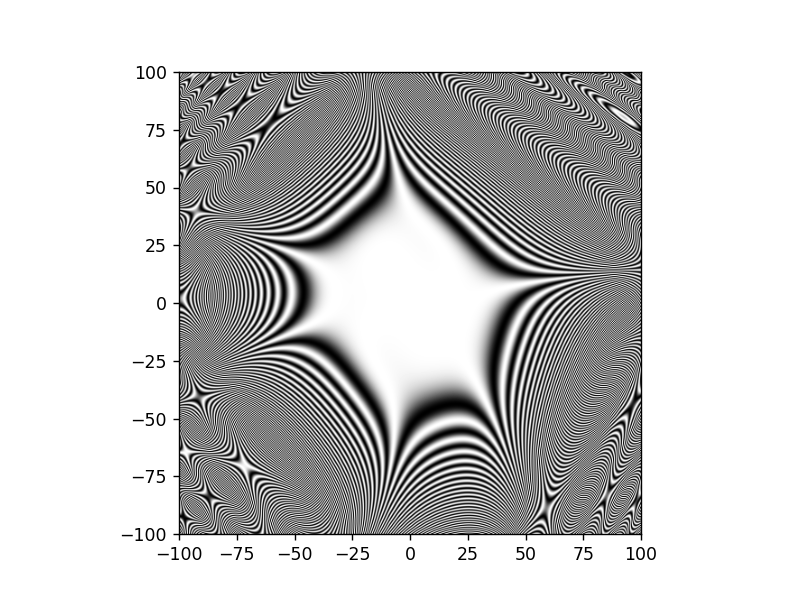

<IPython.core.display.Javascript object>


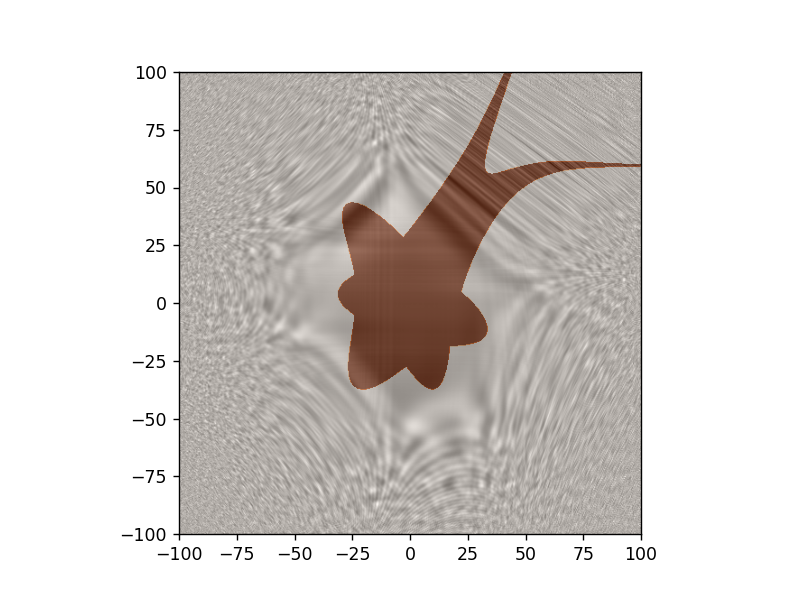

In [29]:
size = 512
ab['C10'] = -0
#ab['C50'] = ab['C50']*1.10
ronchigram, infinite_magnification = get_ronchigram_2(512, ab, threshold=5)

cmap = plt.cm.gray
plt.figure()
plt.imshow(np.cos(ab['chi']), cmap=cmap, aspect='equal', extent=extent)

plt.figure()
plt.imshow(ronchigram, cmap=cmap, aspect='equal', extent=extent)

plt.imshow(infinite_magnification, alpha=.5, cmap ='Oranges', extent=extent)

### Axial and Radial Infinite Magnification Shapes from Hessian

Well asuming we know the center, at least approximatively, then the inner points should be radial and the other axial.

In polar coodinates the distance from the center will give away which point is which.

<IPython.core.display.Javascript object>


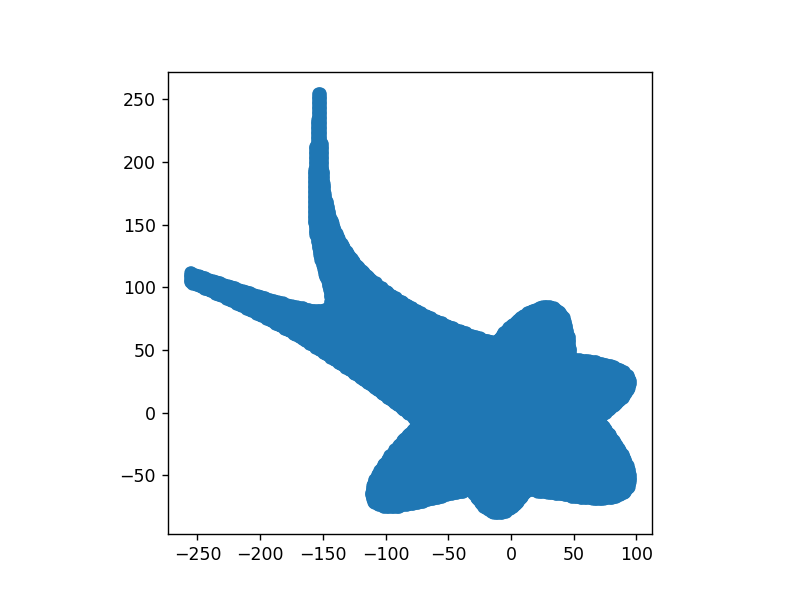

In [30]:
p = np.zeros(infinite_magnification.shape)
p = np.where(infinite_magnification > .9) 
p = np.array(p)
p[0] = p[0,:]-size/2
p[1] = p[1,:]-size/2

plt.figure()
plt.scatter(p[0],p[1])
plt.gca().set_aspect('equal')

(659,)


<IPython.core.display.Javascript object>


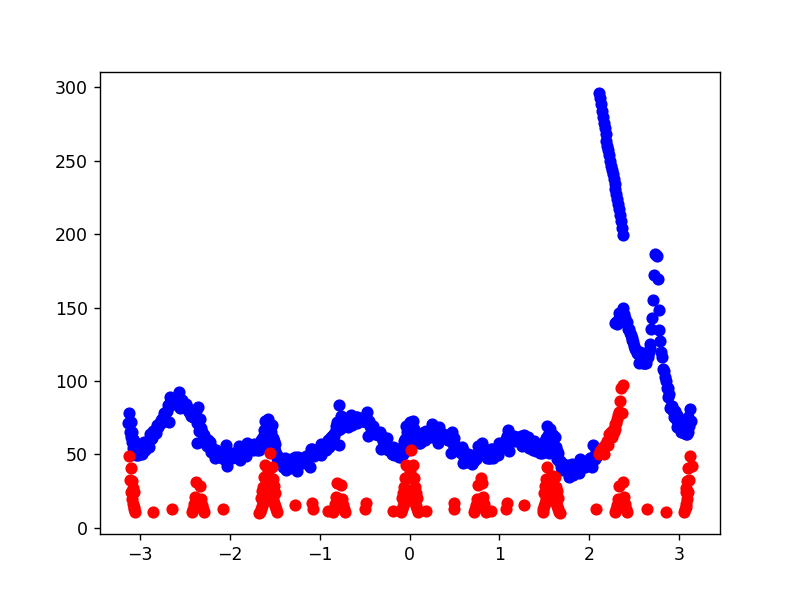

In [31]:
p = np.zeros(infinite_magnification.shape)
p = np.where(infinite_magnification > .9) 
p = np.array(p)
p[0] = p[0,:]-size/2
p[1] = p[1,:]-size/2

r = np.array([np.arctan2(p[1], p[0]), np.sqrt(p[0]**2+p[1]**2)])

rs = np.argsort(r[0])


rr = r.copy()
rr[0] = np.round(r[0,rs],2)
rr[1] = r[1,rs]
start= 0
rad_points = []
ax_points = []
other_points = []
points = []
value,indices,counts = np.unique(rr[0,:], return_index  = True, return_counts =True) 
for i in range(len(counts)):
    xx = np.sort(rr[1,indices[i]:indices[i]+counts[i]])
    #print(xx)
    two = 0
    for j in range(1,counts[i]):
        if xx[j]-xx[j-1] > 10:
            two = 1
            points.append([value[i],np.average(xx[:j])])
            rad_points.append(len(points)-1)
            points.append([value[i],np.average(xx[j:])])
            ax_points.append(len(points)-1)
    if two== 0:
        points.append([value[i],np.average(xx)])
        
        if len(ax_points)>0:
            if np.abs(np.average(xx)- points[ax_points[-1]][1]) <np.abs(np.average(xx)- points[rad_points[-1]][1]):
                ax_points.append(len(points)-1)
            else:
                rad_points.append(len(points)-1)
        else:
            other_points.append(len(points)-1)
for i in range(len (other_points)):
    if np.abs(points[ax_points[0]][1]- points[other_points[i]][1]) <np.abs(points[rad_points[0]][1]- points[other_points[i]][1]):
        ax_points.append(other_points[i])
    else:
        rad_points.append(other_points[i])
print(np.array(ax_points).shape)        
plt.figure()

#plt.scatter(r[0,rs], r[1,rs], color = 'red', alpha = 0.3)
#plt.scatter(r[0,rs]+2*np.pi%(2*np.pi) , r[1,rs], color = 'red', alpha = 0.3)

plt.scatter(np.array(points)[ax_points,0],np.array(points)[ax_points,1], color = 'blue')
plt.scatter(np.array(points)[rad_points,0],np.array(points)[rad_points,1], color = 'red');
#plt.scatter(np.array(points)[other_points,0],np.array(points)[other_points,1], color = 'green');


On the image

<IPython.core.display.Javascript object>


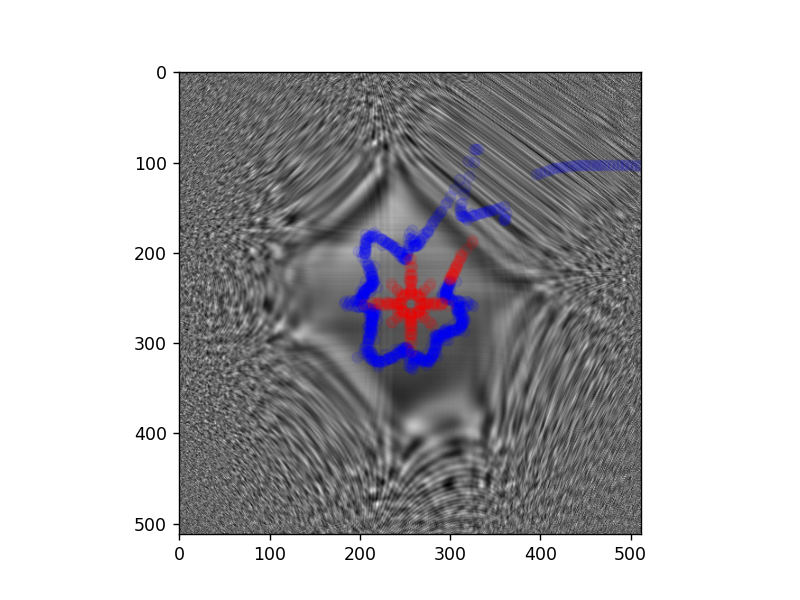

In [32]:

ax_y = np.cos(np.array(points)[ax_points,0])*np.array(points)[ax_points,1]+size/2
ax_x = np.sin(np.array(points)[ax_points,0])*np.array(points)[ax_points,1]+size/2
rad_y = np.cos(np.array(points)[rad_points,0])*np.array(points)[rad_points,1]+size/2
rad_x = np.sin(np.array(points)[rad_points,0])*np.array(points)[rad_points,1]+size/2

plt.figure()
plt.imshow(ronchigram, cmap=cmap, aspect='equal')
plt.scatter(ax_x, ax_y, color = 'blue', alpha = 0.1)
plt.scatter(rad_x, rad_y, color = 'red', alpha = 0.1);



## The Electron Probe Shape

The shape of the electron probe is given by the absolute of the Fourier Tranform of the aberration function $\chi$multiplied by the aperture function $A_k$ 

The ideal defocus and resolution are a little different from phase contrast imaging [see Contrast Transfer function](CH3-CTF.ipynb).

### Aperture Size
Especially important is to determine the optimum size for the probe forming (condensor) aperture in STEM mode .
In the table below the formulas for uncorrected miscroscopes (spherical aberration limits resolution)  for TEM and STEM are summarized:

Source    |     Aperture        |     Defocus   |      Resolution
----------|----------------|--------------------|-----
Uncorrected (BF) | 1.51$(\frac{\lambda}{C_{30}})^{\frac{1}{4}}$  | -1.16$( C_{30} \lambda)^{\frac{1}{2}}$  |0.66$(C_{30}\lambda^3)^{\frac{1}{4}}$
Uncorrected (ADF)| 1.41$(\frac{\lambda}{C_{30}})^{\frac{1}{4}}$  |-$(C_{30} \lambda)^{\frac{1}{2}}$      |0.43$(C_{30}\lambda^3)^{\frac{1}{4}}$

Please note that defoci for BF STEM and *HRTEM* are the same because of the reciprocity theorem.

In [36]:
C30 = 2.2*1e6
acceleration_voltage = 200000
wavelength = it.get_wavelength(200000)
optimum_aperture = 1.41 *(wavelength/C30)**0.25
resolution= 0.43 *(C30*wavelength**3)**0.25
print(f' A microscope with a Cs of {C30/1e6} mm at {acceleration_voltage/1000:.0f} kV has an optimum aperture of {optimum_aperture*1000:.1f} mrad in STEM mode')
print(f' That will give a probe diameter of {resolution:.2f} nm')

 A microscope with a Cs of 2.2 mm at 200 kV has an optimum aperture of 8.2 mrad in STEM mode
 That will give a probe diameter of 0.19 nm


### Probe Shape Calculation
The probe shape is defined as the absolute of the 
inverse of the aberration function which is limited by an aperture.



In [37]:

def make_probe (chi, aperture):
    chi2 = np.fft.ifftshift(chi)
    chiT = np.fft.ifftshift (np.vectorize(complex)(np.cos(chi2), -np.sin(chi2)) )
    ## Aply aperture function
    chiT = chiT*aperture
    ## inverse fft of aberration function
    i2  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift (chiT)))
    ## intensity
    probe = np.real(i2 * np.conjugate(i2))

    return probe


Change the aberration coefficients to see the effect on the probe shape. The circle is for a 0.2 nm probe size.

Acceleration voltage 200.0kV => wavelength 2.51pm


<IPython.core.display.Javascript object>


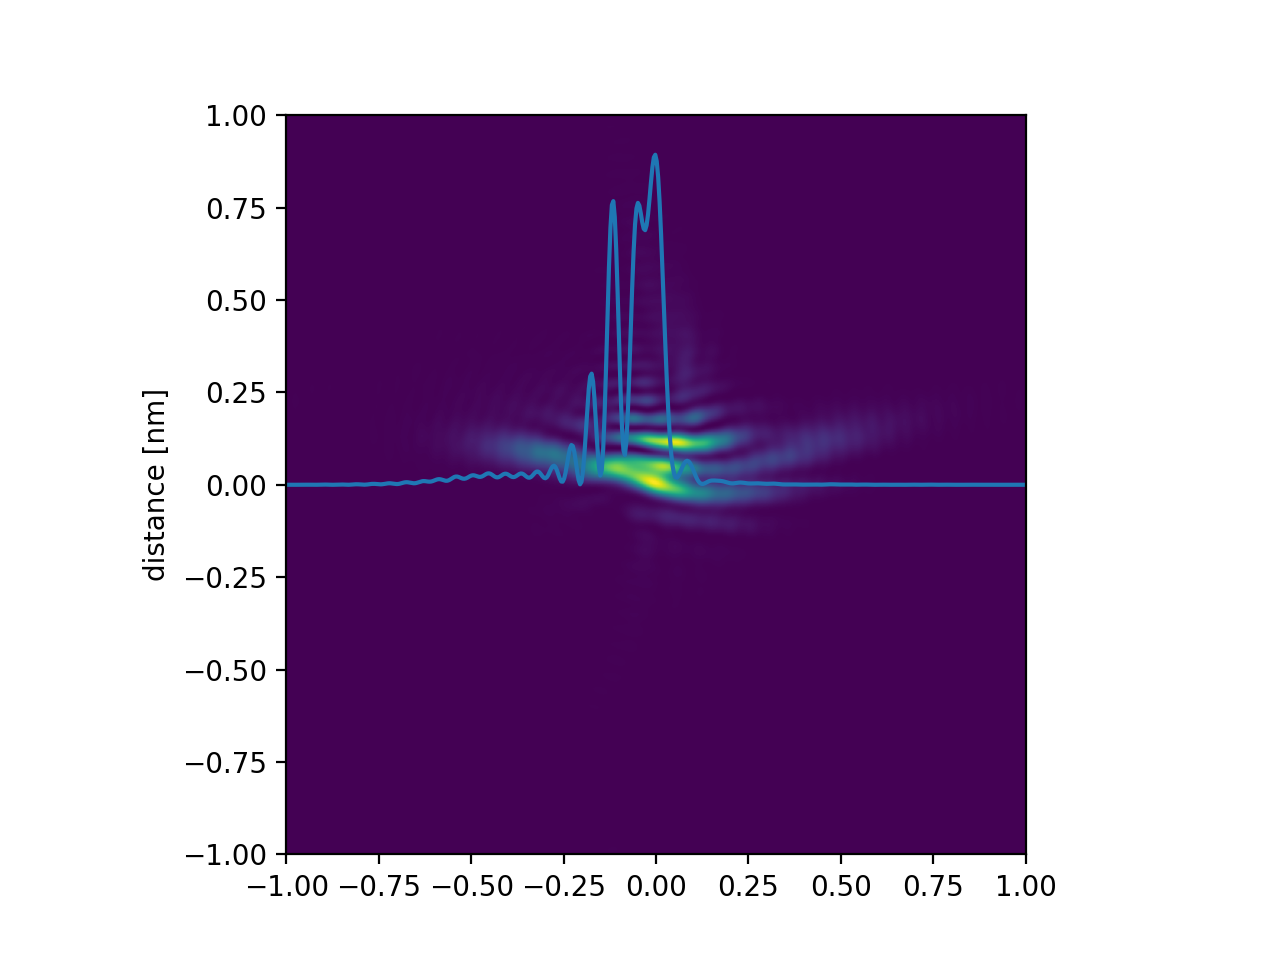

In [38]:
ab['C10'] = -6
ab['C12a'] = 0
ab['FOV'] = 2
ab['convergence_angle'] = 30 # in mrad

sizeX = sizeY =512

chi, A_k  = get_chi( ab, sizeX, sizeY,  verbose= True)
probe = make_probe (chi, A_k)
profile = probe[:, 256]
extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)]
plt.figure()
plt.imshow(probe, extent = extent)
plt.ylabel('distance [nm]');
plt.plot(np.linspace(-ab['FOV']/2,ab['FOV']/2,profile.shape[0]), probe[:,int(probe.shape[1]/2)]/probe.max()*.9)
# probe_size = Circle((0, 0), radius = .1, fill = False, color = 'red')
#plt.gca().add_patch(probe_size);

### All Together

In [39]:


def get_probe( ab, sizeX, sizeY,  scale = 'mrad', verbose= True):
    
    
    chi, A_k  = get_chi( ab, sizeX, sizeY, verbose= False)
    probe = make_probe (chi, A_k)

    V_noise  =np.random.rand(sizeX,sizeY)
    smoothing = 5
    phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

    sigma = 6 ## 6 for carbon and thin

    q_r = np.exp(-1j*sigma * phi_r)
    #q_r = 1-phi_r * sigma

    T_k =  (A_k)*(np.exp(-1j*chi))
    t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

    Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))

    ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

    FOV_reciprocal = 1/ab['FOV']*sizeX/2 
    if scale == '1/nm':
        extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
        ylabel = 'reciprocal distance [1/nm]'
    else :
        FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
        extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
        ylabel = 'reciprocal distance [mrad]'
    ab['extent_reciprocal'] = extent
    ab['ylabel'] =ylabel
    
    return probe, A_k, chi


<IPython.core.display.Javascript object>


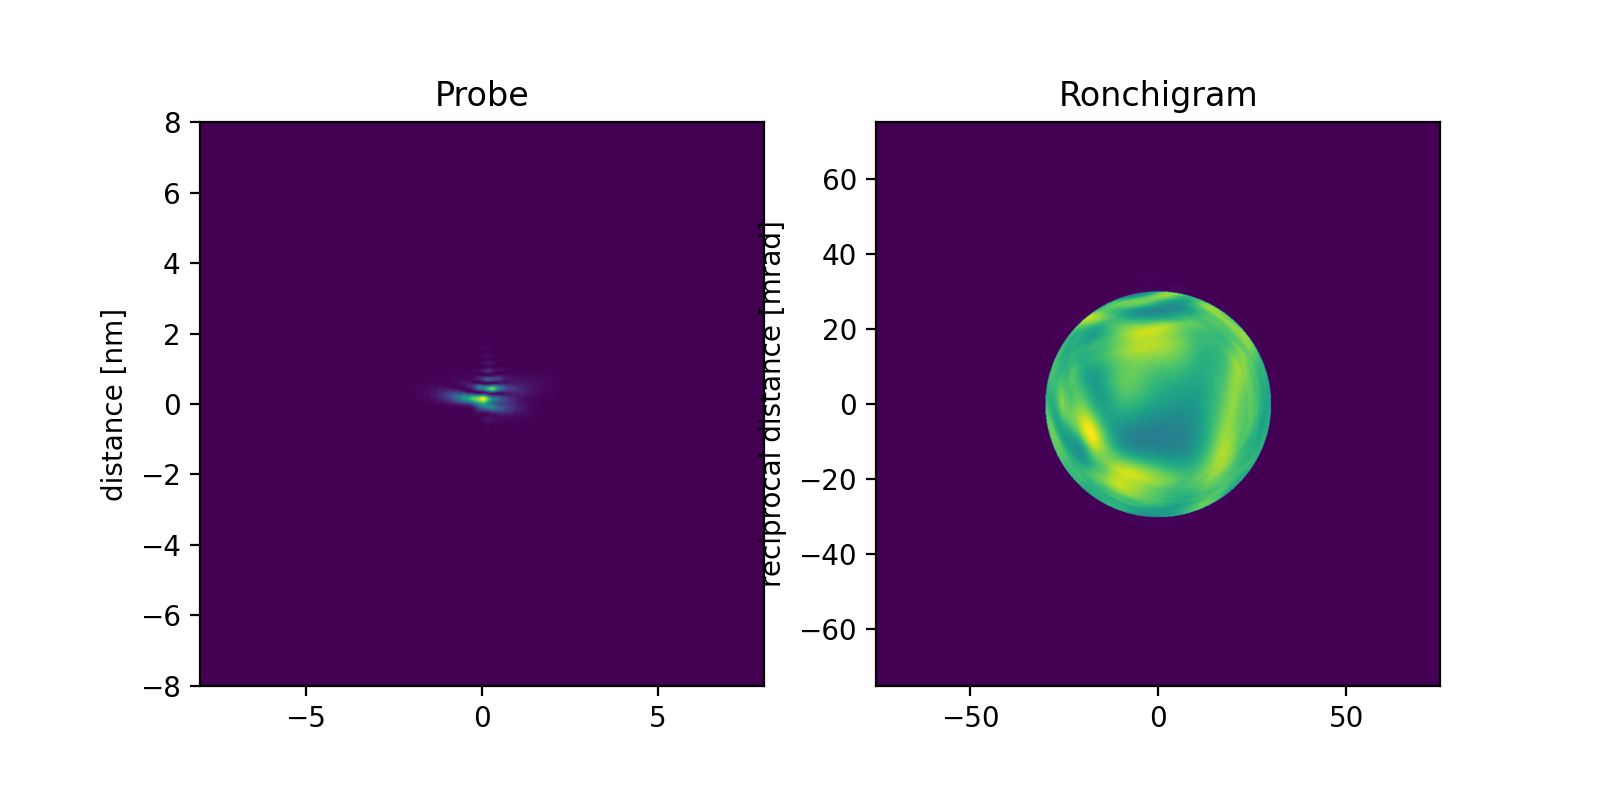

In [41]:
ab['FOV'] = 4
ab['Cc'] = 1
condensor_aperture_radius = ab['convergence_angle'] = 25
probe, A_k, chi  = get_probe( ab, sizeX, sizeY,  scale = 'mrad', verbose= True)

ronchi_FOV = 150 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 30 ## let have a little bit of a view
    
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [nm]')
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')
print_abberrations(ab)
    
    
#condensor_aperture = Circle((0, 0), radius = condensor_aperture_radius)#, fill = False, color = 'red')
#plt.gca().add_patch(condensor_aperture);

## Conclusion



## Homework

Redo this notebook for the aberration corrected STEM 'NionUS200' 

## Appendix

### Aberration Function  and its Derivatives 

In [43]:
from sympy import *
from sympy import re, im, I, E

from sympy.abc import x, y
u,v = symbols('u v')

init_printing(use_unicode=True)

In [44]:
C10 = '(u-I*v)^1*(u+I*v)^1'
C12 = '(u-I*v)^2*(u+I*v)^0'

C12kk = expand (C12)
C12dkuu = diff(expand (C12),u,u)
C12dkuv = diff(expand (C12),u,v)
C12dkvv = diff(expand (C12),v,v)
C10 = '(u-I*v)^1*(u+I*v)^1'
C10kk = expand (C10)
C10dkuu = diff(expand (C10),u,u)
C10dkuv = diff(expand (C10),u,v)
C10dkvv = diff(expand (C10),v,v)
print("chi21 = ab['C12'] *(",C12kk,")/2 +  ab['C10'] *(",C10kk,')/2')
print("d2chidudv = ab['C12'] *(",C12dkuv,")/2 + ab['C10'] *(",C10dkuv,')/2')
print("d2chidu2 = ab['C12'] *(",C12dkuu,")/2 + ab['C10'] *(",C10dkuu,')/2')
print("d2chidv2 = ab['C12'] *(",C12dkvv,")/2 + ab['C10'] *(",C10dkvv,')/2')


chi21 = ab['C12'] *( u**2 - 2*I*u*v - v**2 )/2 +  ab['C10'] *( u**2 + v**2 )/2
d2chidudv = ab['C12'] *( -2*I )/2 + ab['C10'] *( 0 )/2
d2chidu2 = ab['C12'] *( 2 )/2 + ab['C10'] *( 2 )/2
d2chidv2 = ab['C12'] *( -2 )/2 + ab['C10'] *( 2 )/2


In [45]:
chi1 =        ab['C10']  * (u**2 + v**2)/2 \
            + ab['C12a'] * (u**2 - v**2)/2 \
            - ab['C12b'] * u*v
d2chidudv =  -ab['C12b'] 
d2chidu2 =    ab['C10'] + ab['C12a']
d2chidv2 =    ab['C10'] - ab['C12a']

In [46]:
C21 = '(u-I*v)^2*(u+I*v)^1' 
C23 = '(u-I*v)^3*(u+I*v)^0'
dd = 3
kk1 = expand (C21)
dkuu1 = diff(expand (C21),u,u)
dkuv1 = diff(expand (C21),u,v)
dkvv1 = diff(expand (C21),v,v)

kk2 = expand (C23)
dkuu2 = diff(expand (C23),u,u)
dkuv2 = diff(expand (C23),u,v)
dkvv2 = diff(expand (C23),v,v)

print("chi2 =      ab['C21'] *(",kk1,f")/{dd}  +  ab['C23'] *(",kk2,f')/{dd}')

print("dchi2dudv = ab['C21'] *(",dkuv1,f")/{dd} + ab['C23'] *(",dkuv2,f')/{dd}')
print("d2chi2du2 = ab['C21'] *(",dkuu1,f")/{dd} + ab['C23'] *(",dkuu2,f')/{dd}')
print("d2chi2dv2 = ab['C21'] *(",dkvv1,f")/{dd}+  ab['C23'] *(",dkvv2,f')/{dd}')


chi2 =      ab['C21'] *( u**3 - I*u**2*v + u*v**2 - I*v**3 )/3  +  ab['C23'] *( u**3 - 3*I*u**2*v - 3*u*v**2 + I*v**3 )/3
dchi2dudv = ab['C21'] *( 2*(-I*u + v) )/3 + ab['C23'] *( -6*(I*u + v) )/3
d2chi2du2 = ab['C21'] *( 2*(3*u - I*v) )/3 + ab['C23'] *( 6*(u - I*v) )/3
d2chi2dv2 = ab['C21'] *( 2*(u - 3*I*v) )/3+  ab['C23'] *( 6*(-u + I*v) )/3


In [32]:

chi2 =        ab['C21a'] * (u**3 + u*v**2)/3 \
                - ab['C21b'] * (u**2*v + v**3)/3 \
                + ab['C23a'] * (u**3 - 3*u*v**2)/3 \
                - ab['C23b'] * (3*u**2*v - v**3)/3
            
dchi2dudv =   ab['C21a'] * 2/3 * v \
                - ab['C21b'] * 2/3 * u \
                - ab['C23a'] * 2 * v \
                - ab['C23b'] * 2 * u 

    
d2chi2du2 =   ab['C21a'] * 2 * u \
               - ab['C21b'] * 2/3 * v \
               + ab['C23a'] * 2 * u \
               - ab['C23b'] * 2 * v

d2chi2dv2 =    ab['C21a'] * 2/3* u \
                - ab['C21b'] * 2 * v \
                -  ab['C23a'] * 2 * u \
                +  ab['C23b'] * 2 * v


In [33]:
C30 = '(u-I*v)^2*(u+I*v)^2' 
C32 = '(u-I*v)^3*(u+I*v)^1'
C34 = '(u-I*v)^4*(u+I*v)^0'

dd = 4
kk1 = expand (C30)
dkuu1 = diff(expand (C30),u,u)
dkuv1 = diff(expand (C30),u,v)
dkvv1 = diff(expand (C30),v,v)

kk2 = expand (C32)
dkuu2 = diff(expand (C32),u,u)
dkuv2 = diff(expand (C32),u,v)
dkvv2 = diff(expand (C32),v,v)


kk3 = expand (C34)
dkuu3 = diff(expand (C34),u,u)
dkuv3 = diff(expand (C34),u,v)
dkvv3 = diff(expand (C34),v,v)
print("chi3 =      ab['C30'] *(",kk1,f")/{dd}  +  ab['C32'] *(",kk2,f")/{dd}  +  ab['C34'] *(",kk3,f')/{dd}')
print("dchi3dudv = ab['C30'] *(",dkuv1,f")/{dd} + ab['C32'] *(",dkuv2,f")/{dd} + ab['C34'] *(",dkuv3,f')/{dd}')
print("d2chi3du2 = ab['C30'] *(",dkuu1,f")/{dd} + ab['C32'] *(",dkuu2,f")/{dd} +  ab['C34'] *(",dkuu3,f')/{dd}')
print("d2chi3dv2 = ab['C30'] *(",dkvv1,f")/{dd}+  ab['C32'] *(",dkvv2,f")/{dd}+  ab['C34'] *(",dkvv3,f')/{dd}')


chi3 =      ab['C30'] *( u**4 + 2*u**2*v**2 + v**4 )/4  +  ab['C32'] *( u**4 - 2*I*u**3*v - 2*I*u*v**3 - v**4 )/4  +  ab['C34'] *( u**4 - 4*I*u**3*v - 6*u**2*v**2 + 4*I*u*v**3 + v**4 )/4
dchi3dudv = ab['C30'] *( 8*u*v )/4 + ab['C32'] *( -6*I*(u**2 + v**2) )/4 + ab['C34'] *( 12*(-I*u**2 - 2*u*v + I*v**2) )/4
d2chi3du2 = ab['C30'] *( 4*(3*u**2 + v**2) )/4 + ab['C32'] *( 12*u*(u - I*v) )/4 +  ab['C34'] *( 12*(u**2 - 2*I*u*v - v**2) )/4
d2chi3dv2 = ab['C30'] *( 4*(u**2 + 3*v**2) )/4+  ab['C32'] *( -12*v*(I*u + v) )/4+  ab['C34'] *( 12*(-u**2 + 2*I*u*v + v**2) )/4


In [34]:
chi3 =        ab['C30']  * (u**4 + 2*u**2*v**2 + v**4)/4 \
            + ab['C32a'] * (u**4 - v**4 )/4 \
            - ab['C32b'] * (u**3*v + u*v**3)/2 \
            + ab['C34a'] * (u**4 - 6*u**2*v**2 + v**4)/4 \
            - ab['C34b'] * (4*u**3*v - 4*u*v**3)/4

dchi3dudv =   ab['C30']  * 2*u*v \
            + ab['C32a'] * 0 \
            - ab['C32b'] * 3/2*(u**2+ v**2) \
            - ab['C34a'] * 6*u*v \
            - ab['C34b'] * 3*(u**2 - v**2) 

d2chi3du2 =   ab['C30']  * (3*u**2 + v**2) \
            + ab['C32a'] * 3*u**2  \
            - ab['C32b'] * 3*u*v \
            + ab['C34a'] * (3*u**2 - 3*v**2) \
            - ab['C34b'] * 6*u*v
d2chi3dv2 =   ab['C30']  * (u**2 + 3*v**2) \
            - ab['C32a'] * 3*v**2 \
            - ab['C32b'] * 3*v*u \
            - ab['C34a'] * 3*(u**2 - v**2) \
            + ab['C34b'] * 6*u*v

In [35]:
C41 = '(u-I*v)^3*(u+I*v)^2' 
C43 = '(u-I*v)^4*(u+I*v)^1'
C45 = '(u-I*v)^5*(u+I*v)^0'
dd = 5
kk1 = expand (C41)
dkuu1 = diff(expand (C41),u,u)
dkuv1 = diff(expand (C41),u,v)
dkvv1 = diff(expand (C41),v,v)

kk2 = expand (C43)
dkuu2 = diff(expand (C43),u,u)
dkuv2 = diff(expand (C43),u,v)
dkvv2 = diff(expand (C43),v,v)

kk3 = expand (C45)
dkuu3 = diff(expand (C45),u,u)
dkuv3 = diff(expand (C45),u,v)
dkvv3 = diff(expand (C45),v,v)
print("chi4 =      ab['C41'] *(",kk1,f")/{dd}  +  ab['C43'] *(",kk2,f")/{dd}  +  ab['C45'] *(",kk3,f')/{dd}')
print("chi4 =      C_{41} *(",kk1,f")/{dd}  +  C_{43} *(",kk2,f")/{dd}  +  C_{45} *(",kk3,f')/{dd}')

print("dchi4dudv = ab['C41'] *(",dkuv1,f")/{dd} + ab['C43'] *(",dkuv2,f")/{dd} + ab['C45'] *(",dkuv3,f')/{dd}')
print("d2chi4du2 = ab['C41'] *(",dkuu1,f")/{dd} + ab['C43'] *(",dkuu2,f")/{dd} +  ab['C45'] *(",dkuu3,f')/{dd}')
print("d2chi4dv2 = ab['C41'] *(",dkvv1,f")/{dd}+  ab['C43'] *(",dkvv2,f")/{dd}+  ab['C45'] *(",dkvv3,f')/{dd}')


chi4 =      ab['C41'] *( u**5 - I*u**4*v + 2*u**3*v**2 - 2*I*u**2*v**3 + u*v**4 - I*v**5 )/5  +  ab['C43'] *( u**5 - 3*I*u**4*v - 2*u**3*v**2 - 2*I*u**2*v**3 - 3*u*v**4 + I*v**5 )/5  +  ab['C45'] *( u**5 - 5*I*u**4*v - 10*u**3*v**2 + 10*I*u**2*v**3 + 5*u*v**4 - I*v**5 )/5
chi4 =      C_{41} *( u**5 - I*u**4*v + 2*u**3*v**2 - 2*I*u**2*v**3 + u*v**4 - I*v**5 )/5  +  C_43 *( u**5 - 3*I*u**4*v - 2*u**3*v**2 - 2*I*u**2*v**3 - 3*u*v**4 + I*v**5 )/5  +  C_45 *( u**5 - 5*I*u**4*v - 10*u**3*v**2 + 10*I*u**2*v**3 + 5*u*v**4 - I*v**5 )/5
dchi4dudv = ab['C41'] *( 4*(-I*u**3 + 3*u**2*v - 3*I*u*v**2 + v**3) )/5 + ab['C43'] *( -12*(I*u**3 + u**2*v + I*u*v**2 + v**3) )/5 + ab['C45'] *( 20*(-I*u**3 - 3*u**2*v + 3*I*u*v**2 + v**3) )/5
d2chi4du2 = ab['C41'] *( 4*(5*u**3 - 3*I*u**2*v + 3*u*v**2 - I*v**3) )/5 + ab['C43'] *( 4*(5*u**3 - 9*I*u**2*v - 3*u*v**2 - I*v**3) )/5 +  ab['C45'] *( 20*(u**3 - 3*I*u**2*v - 3*u*v**2 + I*v**3) )/5
d2chi4dv2 = ab['C41'] *( 4*(u**3 - 3*I*u**2*v + 3*u*v**2 - 5*I*v**3) )/5+ 

In [36]:
chi4 =        ab['C41a'] * (u**5 + 2*u**3*v**2 + u*v**4)/5 \
            - ab['C41b'] * (u**4*v + 2*u**2*v**3 + v**5)/5 \
            + ab['C43a'] * (u**5 - 2*u**3*v**2 - 3*u*v**4)/5 \
            - ab['C43b'] * (3*u**4*v + 2*u**2*v**3 - v**5)/5 \
            + ab['C45a'] * (u**5 - 10*u**3*v**2 + 5*u*v**4)/5\
            - ab['C45b'] * (5*u**4*v -10*u**2*v**3 + v**5)/5
        
        

d2chi4dudv =  ab['C41a'] * 4/5*(3*u**2*v + v**3) \
            - ab['C41b'] * 4/5*(u**3 + 3*u*v**2) \
            - ab['C43a'] * 12/5*(u**2*v + v**3) \
            - ab['C43b'] * 12/5*(u**3 + u*v**2) \
            - ab['C45a'] * 4*(3*u**2*v - v**3) \
            - ab['C45b'] * 4*(u**3 - 3*u*v**2) 
        
d2chi4du2 =   ab['C41a'] * 4/5*(5*u**3 + 3*u*v**2) \
            - ab['C41b'] * 4/5*(3*u**2*v + v**3) \
            + ab['C43a'] * 4/5*(5*u**3 - 3*u*v**2 ) \
            - ab['C43b'] * 4/5*(9*u**2*v + v**3) \
            + ab['C45a'] * 4*(u**3 - 3*u*v**2) \
            - ab['C45b'] * 4*(3*u**2*v - v**3) 

d2chi4dv2 =   ab['C41a'] * 4/5*(u**3 + 3*u*v**2) \
            - ab['C41b'] * 4/5*(3*u**2*v + 5*v**3) \
            - ab['C43a'] * 4/5*(u**3 + 9*u*v**2) \
            - ab['C43b'] * 4/5*(3*u**2*v - 5*v**3) \
            - ab['C45a'] * 4*(u**3 - 3*u*v**2) \
            + ab['C45b'] * 4*(3*u**2*v - v**3)


In [37]:
C50 = '(u-I*v)^3*(u+I*v)^3' 
C52 = '(u-I*v)^4*(u+I*v)^2'
C54 = '(u-I*v)^5*(u+I*v)^1'
C56 = '(u-I*v)^6*(u+I*v)^0'

dd = 6
kk1 = expand (C50)
dkuu1 = diff(expand (C50),u,u)
dkuv1 = diff(expand (C50),u,v)
dkvv1 = diff(expand (C50),v,v)

kk2 = expand (C52)
dkuu2 = diff(expand (C52),u,u)
dkuv2 = diff(expand (C52),u,v)
dkvv2 = diff(expand (C52),v,v)

kk3 = expand (C54)
dkuu3 = diff(expand (C54),u,u)
dkuv3 = diff(expand (C54),u,v)
dkvv3 = diff(expand (C54),v,v)

kk4 = expand (C56)
dkuu4 = diff(expand (C56),u,u)
dkuv4 = diff(expand (C56),u,v)
dkvv4 = diff(expand (C56),v,v)

print("chi5 =      ab['C50'] *(",kk1,f")/{dd}  +  ab['C52'] *(",kk2,f")/{dd}  +  ab['C54'] *(",kk3,f")/{dd}  +  ab['C56'] *(",kk4,f')/{dd}')
print("chi5 =      C_{50} (",kk1,f")/{dd}  +  C_{52} (",kk2,f")/{dd}  +  C_{54} *(",kk3,f")/{dd}  + C_{56} (",kk4,f')/{dd}')
print("dchi5dudv = ab['C50'] *(",dkuv1,f")/{dd} + ab['C52'] *(",dkuv2,f")/{dd} + ab['C54'] *(",dkuv3,f")/{dd} + ab['C56'] *(",dkuv4,f')/{dd}')
print("d2chi5du2 = ab['C50'] *(",dkuu1,f")/{dd} + ab['C52'] *(",dkuu2,f")/{dd} + ab['C54'] *(",dkuu3,f")/{dd} +  ab['C56'] *(",dkuu4,f')/{dd}')
print("d2chi5dv2 = ab['C50'] *(",dkvv1,f")/{dd} + ab['C52'] *(",dkvv2,f")/{dd} + ab['C54'] *(",dkvv3,f")/{dd}+  ab['C56'] *(",dkvv4,f')/{dd}')


chi5 =      ab['C50'] *( u**6 + 3*u**4*v**2 + 3*u**2*v**4 + v**6 )/6  +  ab['C52'] *( u**6 - 2*I*u**5*v + u**4*v**2 - 4*I*u**3*v**3 - u**2*v**4 - 2*I*u*v**5 - v**6 )/6  +  ab['C54'] *( u**6 - 4*I*u**5*v - 5*u**4*v**2 - 5*u**2*v**4 + 4*I*u*v**5 + v**6 )/6  +  ab['C56'] *( u**6 - 6*I*u**5*v - 15*u**4*v**2 + 20*I*u**3*v**3 + 15*u**2*v**4 - 6*I*u*v**5 - v**6 )/6
chi5 =      C_{50} ( u**6 + 3*u**4*v**2 + 3*u**2*v**4 + v**6 )/6  +  C_52 ( u**6 - 2*I*u**5*v + u**4*v**2 - 4*I*u**3*v**3 - u**2*v**4 - 2*I*u*v**5 - v**6 )/6  +  C_54 *( u**6 - 4*I*u**5*v - 5*u**4*v**2 - 5*u**2*v**4 + 4*I*u*v**5 + v**6 )/6  + C_56 ( u**6 - 6*I*u**5*v - 15*u**4*v**2 + 20*I*u**3*v**3 + 15*u**2*v**4 - 6*I*u*v**5 - v**6 )/6
dchi5dudv = ab['C50'] *( 24*u*v*(u**2 + v**2) )/6 + ab['C52'] *( 2*(-5*I*u**4 + 4*u**3*v - 18*I*u**2*v**2 - 4*u*v**3 - 5*I*v**4) )/6 + ab['C54'] *( 20*(-I*u**4 - 2*u**3*v - 2*u*v**3 + I*v**4) )/6 + ab['C56'] *( 30*(-I*u**4 - 4*u**3*v + 6*I*u**2*v**2 + 4*u*v**3 - I*v**4) )/6
d2chi5du2 = ab['C50'] *( 

In [38]:
chi5 =     ab['C50']  *( u**6 + 3*u**4*v**2 + 3*u**2*v**4 + v**6 )/6\
         + ab['C52a'] * (u**6 + u**4*v**2 - u**2*v**4 - v**6 )/6\
         - ab['C52b'] * (2*u**5*v + 4*u**3*v**3 + 2*u*v**5)/6 \
         + ab['C54a'] * (u**6 - 5*u**4*v**2 - 5*u**2*v**4 + v**6)/6  \
         - ab['C54b'] * (4*u**5*v - 4*u*v**5)/6 \
         + ab['C56a'] * (u**6 - 15*u**4*v**2 + 15*u**2*v**4 - v**6 )/6\
         - ab['C56b'] * (6*u**5*v - 20*u**3*v**3 + 6*u*v**5)/6
    
d2chi5dudv = ab['C50']  * 4*u*v * (u**2 + v**2) \
          + ab['C52a'] * 4/3* (u**3*v - u*v**3) \
          - ab['C52b'] * (5*u**4 + 18*u**2*v**2 + 5*v**4)/3 \
          - ab['C54a'] * 20/3 * (u**3*v + u*v**3 ) \
          - ab['C54b'] * 10/3 * (u**4 - v**4) \
          - ab['C56a'] * 20 * (u**3*v - u*v**3 ) \
          - ab['C56b'] * 5* (u**4 - 6*u**2*v**2 + v**4)

d2chi5du2 = ab['C50']  * (5*u**4 + 6*u**2*v**2 + v**4) \
          + ab['C52a'] * (15*u**4 + 6*u**2*v**2 - v**4)/3 \
          - ab['C52b'] * (20*u**3*v + 12*u*v**3)/3 \
          + ab['C54a'] * 5/3 * (3*u**4 - 6*u**2*v**2 - v**4) \
          - ab['C54b'] * 5/3 * (8*u**3*v)  \
          + ab['C56a'] * 5 * (u**4 - 6*u**2*v**2 + v**4) \
          - ab['C56b'] * 20 * (u**3*v - u*v**3)

d2chi5dv2 = ab['C50']  * (u**4 + 6*u**2*v**2 + 5*v**4) \
          + ab['C52a'] * (u**4 - 6*u**2*v**2 - 15*v**4)/3 \
          - ab['C52b'] * (12*u**3*v +20 *u*v**3)/3 \
          - ab['C54a'] * 5/3 * (u**4 + 6*u**2*v**2 - 3*v**4)\
          + ab['C54b'] * 40/3 * u*v**3\
          - ab['C56a'] * 5 * (u**4 - 6*u**2*v**2 + v**4)\
          + ab['C56b'] * 20 * (u**3*v - u*v**3)

   ## References

